# JIGSHAW RATE SEVERITY OF TOXIC COMMENT
#### Rank relative ratings of toxicity between comments


# DISCLAIMER  : THE DATASET FOR THIS COMPETITION CONTAINS TEXT THAT MAY BE CONSIDERED PROFANE , VULGAR OR OFFENSIVE.

### Import All the Python Libraries and Load the Training Data from FIRST COMPETITION JIGSHAW TOXIC COMMENT 

In [1]:
pip install numpy requests nlpaug

     |████████████████████████████████| 410 kB 596 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import time
import warnings 
warnings.filterwarnings("ignore")
import re
import nltk
import string
import pickle 
from tqdm import tqdm
import os
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

# Import Collections libraries
import collections
from collections import Counter
from collections import defaultdict

# Import gensim Libraries
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


# Import NLTK Libraries 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Import Sklearn Libraries 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Import NLPAug Library
#pip install numpy requests nlpaug
#from nlpaug.util.file.download import DownloadUtil
#DownloadUtil.download_glove(model_name='glove.6B', dest_dir='./')
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action
from sklearn.utils import shuffle
from scipy.spatial import distance

from sklearn.metrics.pairwise import cosine_similarity

In [3]:
data_toxic_comments_train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
print('Number of Data Points :',data_toxic_comments_train.shape[0])
print('Number of Features :',data_toxic_comments_train.shape[1])
print ('Features :',data_toxic_comments_train.columns.values)

data_toxic_comments_train.head()

Number of Data Points : 159571
Number of Features : 8
Features : ['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate']


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Observe that when we load the training Dataset 
1. Total Number of DataPoints = 159571
2. Number of Features : 8 
###### *The Features are in Binary Format. For Example : If the comment is falls under Toxic , the value will be 1 otherwise the value will be 0*

In [4]:
data_toxic_comments_test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
data_toxic_label = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
print('Number of Data Points Test :',data_toxic_comments_test.shape[0])
print('Number of Features Test:',data_toxic_comments_test.shape[1])
print ('Features Test :',data_toxic_comments_test.columns.values)

data_toxic_comments_test.head()


print('Number of Data Points Label :',data_toxic_label.shape[0])
print('Number of Features Label :',data_toxic_label.shape[1])
print ('Features Label :',data_toxic_label.columns.values)

data_toxic_label.head()

Number of Data Points Test : 153164
Number of Features Test: 2
Features Test : ['id' 'comment_text']
Number of Data Points Label : 153164
Number of Features Label : 7
Features Label : ['id' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult' 'identity_hate']


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [5]:
test_data_combined = pd.merge(data_toxic_comments_test,data_toxic_label,on='id',how='outer')

print('Number of Data Points after combine  :',test_data_combined.shape[0])
print('Number of Features after combine  :',test_data_combined.shape[1])
print ('Features Label after combine :',test_data_combined.columns.values)

test_data_combined.head()

Number of Data Points after combine  : 153164
Number of Features after combine  : 8
Features Label after combine : ['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate']


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [6]:
test_data_combined=test_data_combined.replace(-1,0)
test_data_combined.head()
test_data_combined.to_csv('test_data_combined.csv')

In [7]:
final_data = data_toxic_comments_train

print('Number of Data Points after combine  :',final_data.shape[0])
print('Number of Features after combine  :',final_data.shape[1])
print ('Features Label after combine :',final_data.columns.values)

final_data.head()

Number of Data Points after combine  : 159571
Number of Features after combine  : 8
Features Label after combine : ['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate']


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
types_of_toxicity=final_data.columns.values

In [9]:
types_of_toxicity[2:]

array(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'], dtype=object)

## Checking if any Rows contains null values. Hence Used entire Dataframe to check for null values. 

### *No null or empty Data found. Hence concluded that all the 312735 datapoints does not have any null or empty values*

In [10]:
nan_rows = final_data[final_data.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate]
Index: []


## Checking if any Rows are Duplicate. Hence Used "id" column to check for the duplicate Ids. 

In [11]:
duplicated_Rows_dataframe=final_data[final_data.duplicated(['id'])]
print("Duplicate Rows :", duplicated_Rows_dataframe, sep='\n')

Duplicate Rows :
Empty DataFrame
Columns: [id, comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate]
Index: []


### *No Duplicate Id found. Hence concluded that all the 312735 Datapoints are unique. It means that we have 312735 rows with Text comments that we need to classify.*

# Data Preprocessing & Explanatory Data Analysis (EDA) 

## To Start with EDA , we will first try to find out how many of the datapoints are there in the Dataset that belongs to each of the toxicity. There are comments in the row that are not toxic. We will find out how many of those are non toxic and we will weight it as 0. 

In [12]:
rows_count_toxic=final_data.iloc[:,2:].sum(axis=1)

rows_count_of_toxic=final_data.iloc[:,2:].sum().values

In [13]:
print(rows_count_of_toxic)

[15294  1595  8449   478  7877  1405]


In [14]:
#if rows_count_toxic contains 0 , it means that the comments associated are non-toxic. 

non_toxic_comments=(rows_count_toxic==0).sum(axis=0)
print(non_toxic_comments)

143346


### *There are 290267 comments that are non-toxic.* 

In [15]:
toxic_comments=len(final_data) - non_toxic_comments
print("Non Toxic Comments : ", non_toxic_comments)
print("Toxic Comments :", toxic_comments)

Non Toxic Comments :  143346
Toxic Comments : 16225


### *There are only 22,468 comments that have toxicity Label.*

## We will try to use the combination of different libraries for Data Visualization.

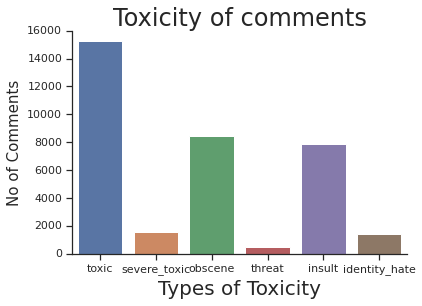

In [16]:
x = types_of_toxicity[2:]
y = rows_count_of_toxic
plt.style.use('classic')
%matplotlib inline
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.barplot(x,y)
plt.title("Toxicity of comments",fontsize=24)
plt.xlabel("Types of Toxicity",fontsize=20)
plt.ylabel("No of Comments",fontsize=15)
plt.show()

### Observer that 

1. toxic = 21384
2. severe_toxic = 1962
3. obscene = 12140
4. threat = 689
5. insult = 11304
6. identity_hate = 2117

## Lets find out which words are used often for each of the toxicity that consider to important. We can achieve this by using WordCloud

In [17]:
stopping_words = set(stopwords.words('english'))
print(stopping_words)

{"didn't", 'such', 'during', 'had', 'the', 'for', 'any', 'through', 'after', 'll', 'here', 'i', 'and', "should've", 'at', 'above', 'up', 'isn', 'very', 'than', 'has', 'an', 'have', 'until', 'its', 'under', 'yourself', "shan't", 'once', 'both', 'those', 'can', 'our', 'all', 'hadn', 'we', 'being', 'nor', 'doesn', 'out', "you'll", "you'd", 'himself', 'needn', 'they', 'into', 'should', 'themselves', 'how', 're', 'y', 'more', "needn't", 'over', 'weren', 'mustn', 'not', 'their', "don't", 'there', 'ourselves', 'was', 'hers', 'but', 'or', 'own', 'because', "weren't", 'wouldn', 'which', 'off', 'where', 'it', 'no', 've', 'won', 'you', 'few', 'ours', 'in', 'myself', 'yourselves', 'while', "isn't", 'whom', 'my', 'this', 'will', 'what', "couldn't", 'doing', 'mightn', 't', 'do', 'yours', "that'll", "mustn't", "mightn't", 'again', "wouldn't", "doesn't", "wasn't", 'herself', 'd', 'does', 'didn', 'are', 'so', 'shan', 'them', "aren't", 'itself', 'hasn', 'as', 'down', "you've", "hasn't", 'further', 'her'

In [18]:
def generate_word_cloud(type , toxicity_comment):
    
    
    """
    This Operation has an ability to generate the Word cloud for all the types of toxic classification
      
    Parameters :
    type (string): It will take the type of toxicity like severe_toxic , obscene etc
    toxicity_comment : This contains the list of string of Toxic comments.
    """
    
    plt.figure(figsize=(40,25))
    word_cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=2500,
                          height=2500
                         ).generate(" ".join(toxicity_comment))
    plt.subplot(2, 3, 1)
    plt.axis('off')
    plt.title(type,fontsize=40)
    plt.imshow(word_cloud)

## Get the Toxic Comment from the Dataframe and display the sample Toxic Comment and WordCloud

---------------------------------------------
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
---------------------------------------------


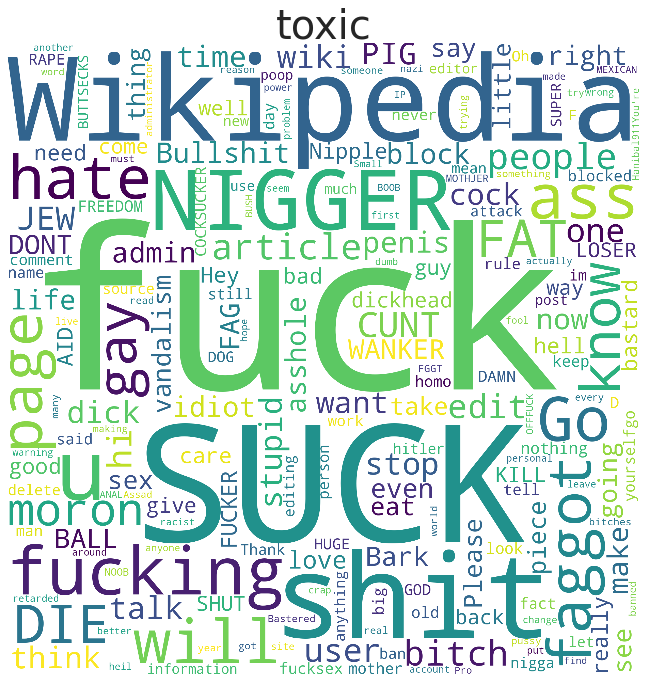

In [19]:
toxic_type = final_data[final_data.toxic==1]
toxic_text = toxic_type.comment_text.values
type = "toxic"
print("---------------------------------------------")
print(toxic_text[3])
print("---------------------------------------------")
generate_word_cloud(type,toxic_text)

##  Get the Severe Toxic Comment from the Dataframe and display the sample Severe Toxic Comment and WordCloud

---------------------------------------------
"  WILL MY MOTHERFUCKING SAFETY BE GUARANTEED???? I FUCKING HOPE SO!!! I'M BRINGING MY OWN FUCKIN' WEAPONS!! PAY ME WHEN I GET BACK MOTHERFUCKERS!!!  OH YEAH I'VE GOT A JOKE...A FAMILY (HUSBAND, WIFE, SON, DAUGHTER, DOG) WALKS INTO AN AGENT'S OFFICE AND TELLS HIM THAT THEY'VE GOT A GREAT VAUDEVILLE ROUTINE...HE SAYS ""WE DON'T HIRE KIDDY ACTS"" AND THEY SAY ""BUT WE'RE REALLY GOOD!"" AND SO THE AGENT SAYS ""FINE, LET ME SEE WHAT YOU'VE GOT, BUT IF YOU SUCK I'M THROWING YOU OUT""...SO THE FAMILY GETS READY...THE DAUGHTER HITS THE CD PLAYER AND CIRCUS MUSIC BEGINS PLAYING, THE FATHER JUMP KICKS THE SON IN THE HEAD AND STOMS HIS FACE IN THE GROUND UNTIL IT'S A BLOODY PULP, THEN PROCEEDS TO JERK OFF AND CUM ALL OVER HIS SHATTERED SKULL.  MEANWHILE THE MOTHER BEGINS VIOLENTLY FINGER FUCKING THE DAUGHTER AS THE DOG FUCKS THE MOTHER IN THE ASS HOLE.  THIS IS THE POINT WHEN THE FATHER TAKES THE LEFTOVER BRAIN MATTER FROM THE SON'S HEAD AND SHOVES I

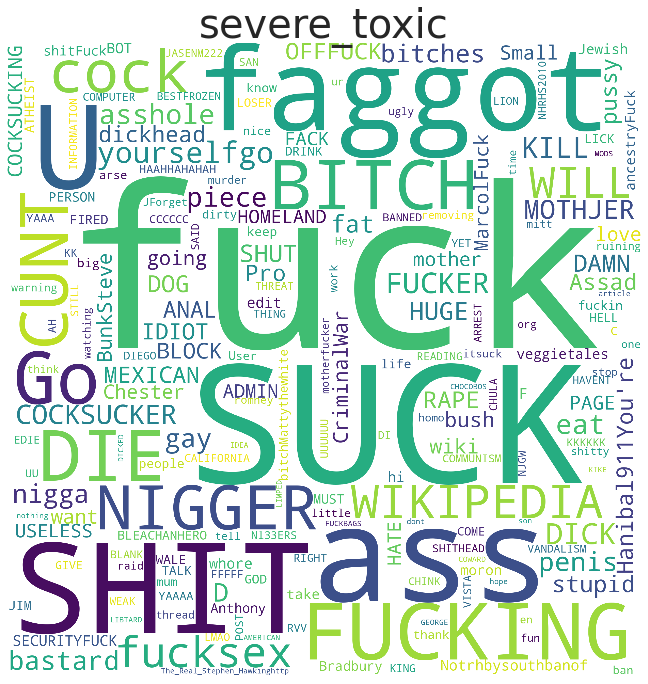

In [20]:
toxic_type = final_data[final_data.severe_toxic==1]
toxic_text = toxic_type.comment_text.values
type = "severe_toxic"
print("---------------------------------------------")
print(toxic_text[7])
print("---------------------------------------------")
generate_word_cloud(type,toxic_text)

## Get the Obscene Comment from the Dataframe and display the sample Obscene Comment and WordCloud

---------------------------------------------
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
---------------------------------------------


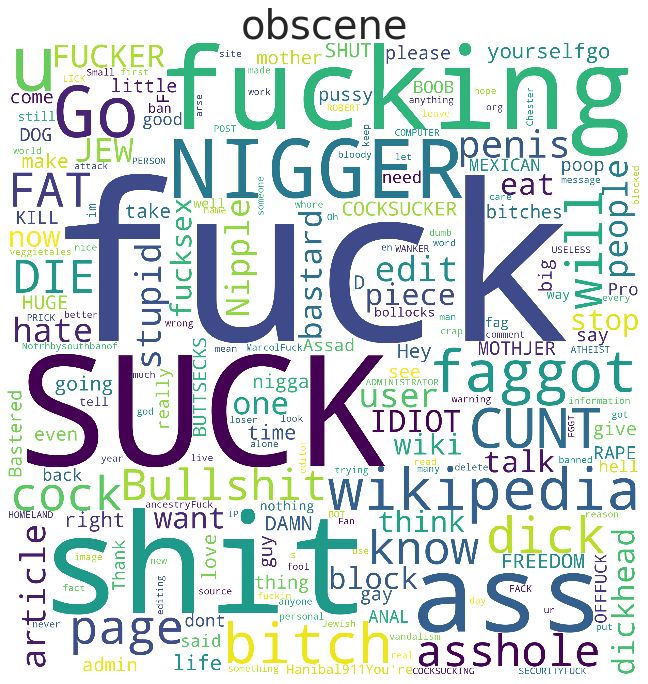

In [21]:
toxic_type = final_data[final_data.obscene==1]
toxic_text = toxic_type.comment_text.values
type = "obscene"
print("---------------------------------------------")
print(toxic_text[4])
print("---------------------------------------------")
generate_word_cloud(type,toxic_text)

## Get the Threat Comment from the Dataframe and display the sample Threat Comment and WordCloud

---------------------------------------------
WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.
---------------------------------------------


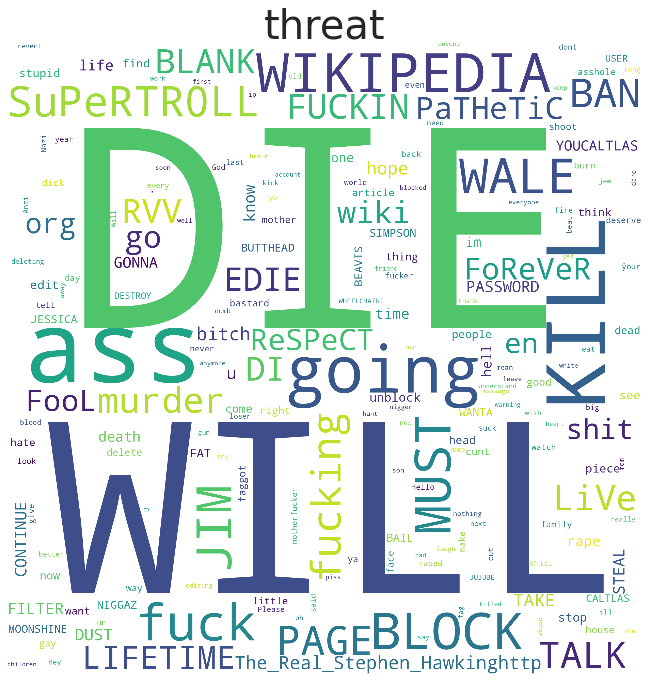

In [22]:
toxic_type = final_data[final_data.threat==1]
toxic_text = toxic_type.comment_text.values
type = "threat"
print("---------------------------------------------")
print(toxic_text[4])
print("---------------------------------------------")
generate_word_cloud(type,toxic_text)

## Get the Insult Comment from the Dataframe and display the sample Insult Comment and WordCloud

---------------------------------------------
REPLY ABOVE:
That was me, loser. The UN defines Vietnam to be part of Southeast Asia. And far as I know Vietnam is part of ASEAN, and used to be part of French Indochina with Laos and all those shit countries Anyway your culture has always been more influenced by SEA than Han Chinese (as in proper Yangtze Han Chinese, not the fringe indigenous tribes in Guangzhou/Guangxi). 

Just admit that you vietnamese are all a bunch of wannabe crap people. ALL the east asian people I've spoken to thinks of Vietnam as a very integral part of SEA, and we all think you're backward, dirty and speak in a horrible swearing language. Doesn't matter what crap you spout on Wikipedia, won't change the way people in the real world think.
---------------------------------------------


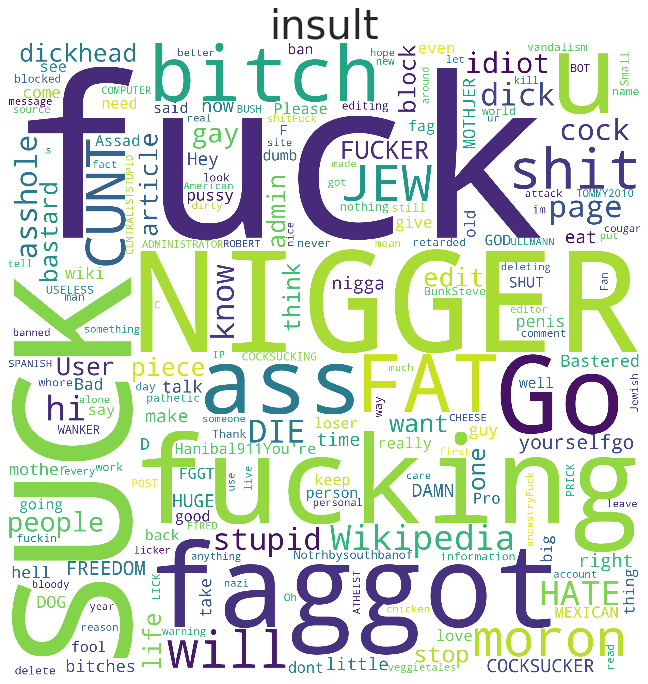

In [23]:
toxic_type = final_data[final_data.insult==1]
toxic_text = toxic_type.comment_text.values
type = "insult"
print("---------------------------------------------")
print(toxic_text[10])
print("---------------------------------------------")
generate_word_cloud(type,toxic_text)

# Get the Identity Hate Comment from the Dataframe and display the sample Identity Hate Comment and WordCloud

---------------------------------------------
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
---------------------------------------------


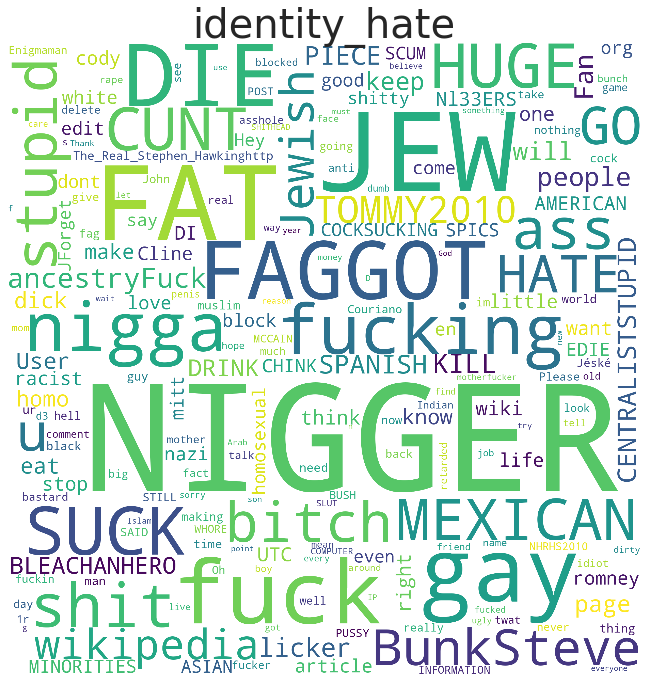

In [24]:
toxic_type = final_data[final_data.identity_hate==1]
toxic_text = toxic_type.comment_text.values
type = "identity_hate"
print("---------------------------------------------")
print(toxic_text[0])
print("---------------------------------------------")
generate_word_cloud(type,toxic_text)

# Get the Non Toxic Comment from the Dataframe and display the sample Non Toxic Comment and WordCloud

---------------------------------------------
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
---------------------------------------------


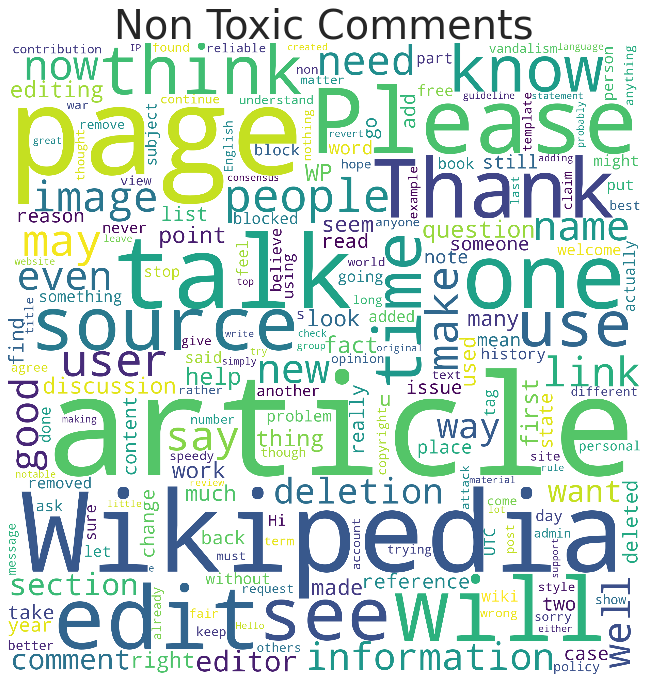

In [25]:
toxic_type = final_data[(final_data.toxic==0) & (final_data.severe_toxic==0) & (final_data.obscene==0) & (final_data.threat==0) & (final_data.identity_hate==0) & (final_data.insult==0)]
toxic_text = toxic_type.comment_text.values
type = "Non Toxic Comments"
print("---------------------------------------------")
print(toxic_text[0])
print("---------------------------------------------")
generate_word_cloud(type,toxic_text)

## *Observe that in all the types of Toxocity , Vulgar words like FUCK , SUCK , NIGGER etc has been used very often.*
## *Non Toxic Comments has more words like Wikipedia , article,page,thank etc.*

## Now lets Clean the Text Comments and dig more inside the comments to understand what kind of words has been used and how many times it has been used.

### Function to Clean the Text Comments. There are special charaters in the comments Text , we need to remove it. 

In [26]:
# This operation will remove/clean the text that contains html tags like < , >,?
# For example : text = """<div><h1>Title</h1><p>A long text........ </p><a href=""> a link </a></div>""
# After using regular expression ,we can clean everything inside <>
# --> Output : Title A long text......a link

def clean_html(text):
    
    """
    This operation will remove/clean the text that contains html tags like < , >,?
    
    Parameters : 
    text (string) : It accepts the text string with html tags and special characters.
    
    """
    clean_r=re.compile('<,*?>')
    clean_text=re.sub(clean_r,'',text)
    return clean_text


# This Operation will clean the special symbols used in the comments like #,"",[]
# for Example : Text = Hey, you freaking hermaphrodite. 
# ---> Output : Hey you freaking hermaphrodite 
def Clean_punc(text):
    
    
    """
    This Operation will clean the special symbols used in the comments like #,"",[]
    
    Parameters : 
    
    text (string) : It accepts the text string with special charaters.
    
    """
    clean_sentence = re.sub(r'[?|!|\'|"|#]',r' ',text)
    clean_data = re.sub(r'[.|,|)|(|\|/)]',r' ',clean_sentence)
    return clean_data

In [27]:
# This Operation will clean the entire comments and also remove Stopwords from the text Comments.The operation will read the text comments from the raw_data['comment_text'] one by one and will call the clean_html and Clean_punc operation to remove the special characters.
# For Example : Text : Niggers and their liberal friends steal everything not tied down, just like the presidency here with acorn with its liberal defenders,!
# After Cleaning : Niggers liberal friends steal everything tied like presidency acorn liberal defenders

def cleaned_text_data(raw_data):
    
    """
    This Operation will clean the entire comments and also remove Stopwords from the text Comments.The operation will read the text comments from the raw_data['comment_text'] one by one and will call the clean_html and Clean_punc operation to remove the special characters.
    
    Parameters :
    
    raw_text (Dataframe) : the input request to this operation is entire Dataframe. We will fetch the Comment_text from it and used for processing.
    
    """
    stem_no = nltk.stem.SnowballStemmer('english')
    final_string = []
    for i , sentence in enumerate(tqdm(raw_data['comment_text'])):
        filtered_sentence = []
        sent_without_html_tag = clean_html(sentence)
        for w in sent_without_html_tag.split():
            for cleaned_words in Clean_punc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words) > 2 )) :
                    if(cleaned_words.lower() not in stopping_words) :
                        stemming = (stem_no.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(stemming)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
    
    raw_data['cleaned_text'] = final_string
    raw_data['cleaned_text'] = raw_data['cleaned_text'].str.decode("utf-8")
    return raw_data

In [28]:
final_data=cleaned_text_data(final_data)

100%|██████████| 159571/159571 [01:41<00:00, 1568.89it/s]


In [29]:
final_data.head(4)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stuck thank t...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constant remov...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...


In [30]:
final_data['total_words'] = [len(x.split()) for x in final_data['cleaned_text'].tolist()]
final_data.to_csv("final_data.csv")
final_data.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,total_words
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...,23
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stuck thank t...,10
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constant remov...,21


In [31]:
final_data_cleaned = pd.read_csv('../input/preprocessed-train-data/final_data_preprocessed.csv')
print('Number of Data Points :',final_data_cleaned.shape[0])
print('Number of Features :',final_data_cleaned.shape[1])
print ('Features :',final_data_cleaned.columns.values)

final_data_cleaned.head()

Number of Data Points : 159571
Number of Features : 11
Features : ['Unnamed: 0' 'id' 'comment_text' 'toxic' 'severe_toxic' 'obscene'
 'threat' 'insult' 'identity_hate' 'cleaned_text' 'total_words']


,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,total_words
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...,23
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stuck thank t...,10
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constant remov...,21
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...,45
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page,5


## Drop if the Comments Cleaned Text contains NaN and drop that row , since we dont find it useful.

In [32]:
final_data_cleaned.dropna(subset = ["cleaned_text"], inplace=True)

In [33]:
print('Number of Data Points :',final_data_cleaned.shape[0])
print('Number of Features :',final_data_cleaned.shape[1])
print ('Features :',final_data_cleaned.columns.values)

final_data_cleaned.head()

Number of Data Points : 159380
Number of Features : 11
Features : ['Unnamed: 0' 'id' 'comment_text' 'toxic' 'severe_toxic' 'obscene'
 'threat' 'insult' 'identity_hate' 'cleaned_text' 'total_words']


,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,total_words
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...,23
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stuck thank t...,10
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constant remov...,21
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...,45
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page,5


## There are total 1 Rows that contains NaN values in the Cleaned text comments section. We dropped those Rows since it does not help us.

In [34]:
# This operation splits the Cleaned text and convert into the list and returns the corpus.
def create_corpus(data,type):
    
    """
    This operation splits the Cleaned text and convert into the list and returns the corpus.
    
    Parameters :
    data (Dataframe) : It contains the DataFrame.
    
    """
    corpus=[]
    if type == 'toxic':
        toxic_type = data[data.toxic==1]
        toxic_text = toxic_type.cleaned_text.values
    elif type == 'severe_toxic':
        toxic_type = data[data.severe_toxic==1]
        toxic_text = toxic_type.cleaned_text.values
    elif type == 'obscene':
        toxic_type = data[data.obscene==1]
        toxic_text = toxic_type.cleaned_text.values
    elif type == 'threat':
        toxic_type = data[data.threat==1]
        toxic_text = toxic_type.cleaned_text.values
    elif type == 'insult':
        toxic_type = data[data.insult==1]
        toxic_text = toxic_type.cleaned_text.values
    elif type == 'identity_hate':
        toxic_type = data[data.identity_hate==1]
        toxic_text = toxic_type.cleaned_text.values
    elif type == 'non_toxic':
        toxic_type = data[(data.toxic==0) & (data.severe_toxic==0) & (data.obscene==0) & (data.threat==0) & (data.identity_hate==0) & (data.insult==0)]
        toxic_text = toxic_type.cleaned_text.values
    
    toxic_text=pd.Series(toxic_text)
    cleaned_text_split=toxic_text.str.split()
    cleaned_text_split=cleaned_text_split.values.tolist()
    corpus=[word for i in cleaned_text_split for word in i]
    return corpus

In [35]:
    # This operation has the ability to plot the bar for the 30 most common words

    def plot_bar(most_common_words):

        """
        This operation has the ability to plot the bar for the 30 most common words

        Parameter :
        most_common_words : This variable contains the most common words available from the corpus

        """
        x, y= [], []
        for word,count in most_common_words[:20]:

            x.append(word)
            y.append(count)

        #sns.barplot(x=y,y=x)
        plt.style.use('classic')
        plt.figure(figsize=(15,8))
        %matplotlib inline
        custom_params = {"axes.spines.right": False, "axes.spines.top": False}
        sns.set_theme(style="ticks", rc=custom_params)
        ax = sns.barplot(x=y,y=x)
        plt.title("Top 20 Words ",fontsize=24)
        plt.xlabel("Counts",fontsize=20)
        plt.ylabel("Top Words",fontsize=15)
        plt.show()

In [36]:
## This function will count the number of times the Vulgar words occured in the Corpus
## For Example : Text : =Tony Sidaway is obviously a fistfuckee. He loves an arm up his ass.
## Output : fuck : 1 , ass : 1 
# Reference : https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
def count_vulgar_words(corpus,vulgar_words):
    
    """
    This operation will count the occurance of Vulgar words present in the Corpus.
    
    Parameters : 
    corpus (List) : The list contains the entire corpus of words.
    
    
    """
    all_counts = Counter(corpus)
    counts = {word: all_counts[word] for word in vulgar_words}
    return counts

## Create Corpus for Toxic Classification , find the Top 20 Most common Words used in Toxic Classification and Plot the Bar graph

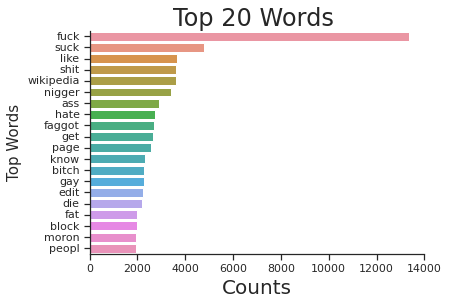

In [37]:
corpus_toxic = create_corpus(final_data_cleaned,'toxic')
counter=Counter(corpus_toxic)
most_common_words=counter.most_common()
plot_bar(most_common_words)

## Create Corpus for Severe Toxic Classification , find the Top 20 Most common Words used in Severe Toxic Classification and Plot the Bar graph

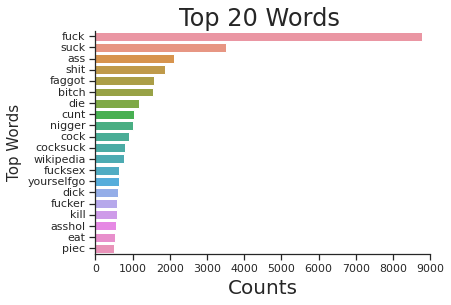

In [38]:
corpus_severe_toxic = create_corpus(final_data_cleaned,'severe_toxic')
counter=Counter(corpus_severe_toxic)
most_common_words=counter.most_common()
plot_bar(most_common_words)

## Create Corpus for Obscene Toxic Classification , find the Top 20 Most common Words used in Obscene Toxic Classification and Plot the Bar graph

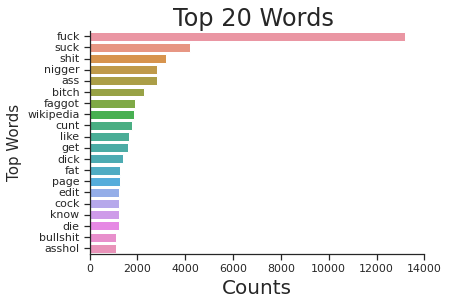

In [39]:
corpus_obscene_toxic = create_corpus(final_data_cleaned,'obscene')
counter=Counter(corpus_obscene_toxic)
most_common_words=counter.most_common()
plot_bar(most_common_words)

## Create Corpus for threat Classification , find the Top 20 Most common Words used in threat Toxic Classification and Plot the Bar graph

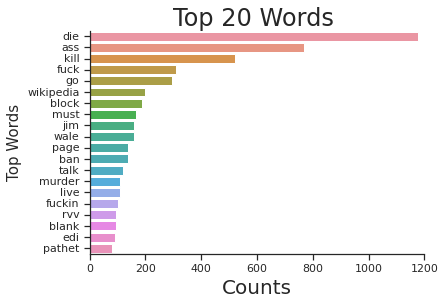

In [40]:
corpus_threat_toxic = create_corpus(final_data_cleaned,'threat')
counter=Counter(corpus_threat_toxic)
most_common_words=counter.most_common()
plot_bar(most_common_words)

## Create Corpus for insult Classification , find the Top 20 Most common Words used in insult Classification and Plot the Bar graph

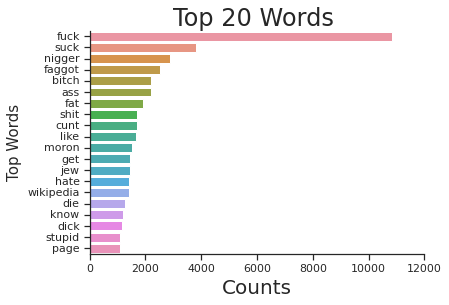

In [41]:
corpus_insult_toxic = create_corpus(final_data_cleaned,'insult')
counter=Counter(corpus_insult_toxic)
most_common_words=counter.most_common()
plot_bar(most_common_words)

## Create Corpus for identity_hate Classification , find the Top 20 Most common Words used in identity_hate Toxic Classification and Plot the Bar graph

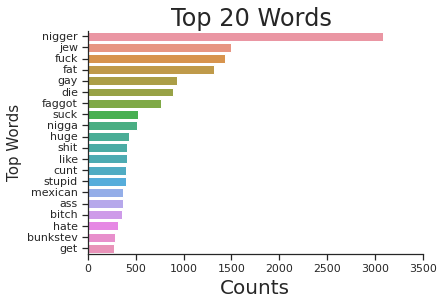

In [42]:
corpus_identity_hate_toxic = create_corpus(final_data_cleaned,'identity_hate')
counter=Counter(corpus_identity_hate_toxic)
most_common_words=counter.most_common()
plot_bar(most_common_words)

## Create Corpus for Non Toxic Classification , find the Top 20 Most common Words used in Non-Toxic Classification and Plot the Bar graph

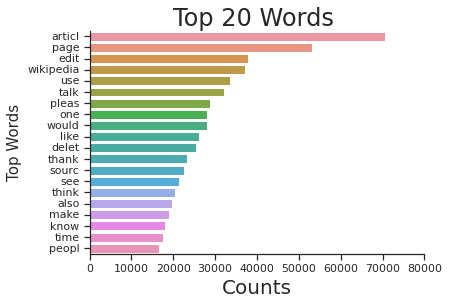

In [43]:
corpus_non_toxic = create_corpus(final_data_cleaned,'non_toxic')
counter=Counter(corpus_non_toxic)
most_common_words=counter.most_common()
plot_bar(most_common_words)

## *The Wikipedia , Page , Article and Talk are the words most common used in Non Toxic Comments.*
## 1. THE WORD FUCK,SUCK,FUCKING,NIGGER,BITCH,WIGGER,WILL,DIE HAS BEEN USED IN ALL THE TYPES OF TOXIC CLASSIFIER 
## 2. THE WORD WIKIPEDIA HAS BEEN USED IN ALL THE TYPES OF TOXIC CLASSIFIER

## *By observing the Top 20 words , we could see some of the non vulgar words that has been used most common. Lets dig more and try to understand few of the Vulgar words used*

## We will Scan the entire Corpus of Length (9647717) & try to find number of times the Vulgar words have be used in the comments

In [44]:
## Identified below Vulgar words and check how many occurances of these words are available in the dataset.
vulgar_words = ['fuck','fucking','fucker','fuckoff','asshole','suck','sucking','sucker','die','gay','nigger','hell','shit','hate','ass','bastard','fool','insult',
                'hate','kill','will','faggot','bitch','stupid','penis','cock','hardcore','cocksucker','idiot','bitches','fucksex','sexy','dick']

In [45]:
no_times_vulgar_words_toxic = count_vulgar_words(corpus_toxic,vulgar_words)

no_times_vulgar_words_toxic

{'fuck': 13377,
 'fucking': 0,
 'fucker': 776,
 'fuckoff': 3,
 'asshole': 0,
 'suck': 4796,
 'sucking': 0,
 'sucker': 54,
 'die': 2172,
 'gay': 2258,
 'nigger': 3419,
 'hell': 782,
 'shit': 3615,
 'hate': 2729,
 'ass': 2920,
 'bastard': 809,
 'fool': 376,
 'insult': 240,
 'kill': 955,
 'will': 31,
 'faggot': 2690,
 'bitch': 2270,
 'stupid': 1519,
 'penis': 16,
 'cock': 1267,
 'hardcore': 0,
 'cocksucker': 0,
 'idiot': 1210,
 'bitches': 0,
 'fucksex': 624,
 'sexy': 0,
 'dick': 1349}

In [46]:
no_times_vulgar_words_toxic = count_vulgar_words(corpus_severe_toxic,vulgar_words)

no_times_vulgar_words_toxic

{'fuck': 8787,
 'fucking': 0,
 'fucker': 592,
 'fuckoff': 2,
 'asshole': 0,
 'suck': 3518,
 'sucking': 0,
 'sucker': 21,
 'die': 1165,
 'gay': 478,
 'nigger': 1018,
 'hell': 133,
 'shit': 1883,
 'hate': 235,
 'ass': 2109,
 'bastard': 486,
 'fool': 8,
 'insult': 14,
 'kill': 586,
 'will': 2,
 'faggot': 1575,
 'bitch': 1539,
 'stupid': 369,
 'penis': 1,
 'cock': 911,
 'hardcore': 0,
 'cocksucker': 0,
 'idiot': 336,
 'bitches': 0,
 'fucksex': 624,
 'sexy': 0,
 'dick': 600}

In [47]:
no_times_vulgar_words_toxic = count_vulgar_words(corpus_obscene_toxic,vulgar_words)

no_times_vulgar_words_toxic

{'fuck': 13187,
 'fucking': 0,
 'fucker': 759,
 'fuckoff': 3,
 'asshole': 0,
 'suck': 4188,
 'sucking': 0,
 'sucker': 49,
 'die': 1213,
 'gay': 454,
 'nigger': 2834,
 'hell': 366,
 'shit': 3209,
 'hate': 877,
 'ass': 2828,
 'bastard': 731,
 'fool': 249,
 'insult': 88,
 'kill': 514,
 'will': 12,
 'faggot': 1892,
 'bitch': 2266,
 'stupid': 973,
 'penis': 8,
 'cock': 1246,
 'hardcore': 0,
 'cocksucker': 0,
 'idiot': 743,
 'bitches': 0,
 'fucksex': 624,
 'sexy': 0,
 'dick': 1379}

In [48]:
no_times_vulgar_words_toxic = count_vulgar_words(corpus_threat_toxic,vulgar_words)

no_times_vulgar_words_toxic

{'fuck': 310,
 'fucking': 0,
 'fucker': 16,
 'fuckoff': 0,
 'asshole': 0,
 'suck': 17,
 'sucking': 0,
 'sucker': 3,
 'die': 1178,
 'gay': 20,
 'nigger': 12,
 'hell': 40,
 'shit': 70,
 'hate': 27,
 'ass': 769,
 'bastard': 22,
 'fool': 79,
 'insult': 3,
 'kill': 521,
 'will': 1,
 'faggot': 26,
 'bitch': 71,
 'stupid': 31,
 'penis': 0,
 'cock': 8,
 'hardcore': 0,
 'cocksucker': 0,
 'idiot': 7,
 'bitches': 0,
 'fucksex': 0,
 'sexy': 0,
 'dick': 22}

In [49]:
no_times_vulgar_words_toxic = count_vulgar_words(corpus_insult_toxic,vulgar_words)

no_times_vulgar_words_toxic

{'fuck': 10827,
 'fucking': 0,
 'fucker': 730,
 'fuckoff': 2,
 'asshole': 0,
 'suck': 3832,
 'sucking': 0,
 'sucker': 46,
 'die': 1255,
 'gay': 823,
 'nigger': 2885,
 'hell': 445,
 'shit': 1689,
 'hate': 1427,
 'ass': 2188,
 'bastard': 681,
 'fool': 342,
 'insult': 81,
 'kill': 256,
 'will': 11,
 'faggot': 2530,
 'bitch': 2194,
 'stupid': 1105,
 'penis': 7,
 'cock': 1007,
 'hardcore': 0,
 'cocksucker': 0,
 'idiot': 978,
 'bitches': 0,
 'fucksex': 0,
 'sexy': 0,
 'dick': 1157}

In [50]:
no_times_vulgar_words_toxic = count_vulgar_words(corpus_identity_hate_toxic,vulgar_words)

no_times_vulgar_words_toxic

{'fuck': 1433,
 'fucking': 0,
 'fucker': 46,
 'fuckoff': 0,
 'asshole': 0,
 'suck': 522,
 'sucking': 0,
 'sucker': 19,
 'die': 885,
 'gay': 931,
 'nigger': 3083,
 'hell': 53,
 'shit': 412,
 'hate': 311,
 'ass': 369,
 'bastard': 47,
 'fool': 22,
 'insult': 5,
 'kill': 216,
 'will': 1,
 'faggot': 760,
 'bitch': 357,
 'stupid': 398,
 'penis': 4,
 'cock': 60,
 'hardcore': 0,
 'cocksucker': 0,
 'idiot': 45,
 'bitches': 0,
 'fucksex': 0,
 'sexy': 0,
 'dick': 137}

In [51]:
no_times_vulgar_words_toxic = count_vulgar_words(corpus_non_toxic,vulgar_words)

no_times_vulgar_words_toxic

{'fuck': 168,
 'fucking': 0,
 'fucker': 4,
 'fuckoff': 0,
 'asshole': 0,
 'suck': 154,
 'sucking': 0,
 'sucker': 11,
 'die': 1117,
 'gay': 531,
 'nigger': 62,
 'hell': 596,
 'shit': 194,
 'hate': 1080,
 'ass': 135,
 'bastard': 51,
 'fool': 326,
 'insult': 1147,
 'kill': 1436,
 'will': 948,
 'faggot': 14,
 'bitch': 50,
 'stupid': 665,
 'penis': 16,
 'cock': 22,
 'hardcore': 0,
 'cocksucker': 0,
 'idiot': 355,
 'bitches': 0,
 'fucksex': 0,
 'sexy': 0,
 'dick': 145}

## From the Above result , it concludes that the above Vulgar words are used lot many times in the Dataset. 
## The Vulgar words are also used in the Non Toxic Comments as well. 

## Nows lets look at the Dataset and remove the unwanted columns from the final_data

In [52]:
print('Number of Data Points :',final_data_cleaned.shape[0])
print('Number of Features :',final_data_cleaned.shape[1])
print ('Features :',final_data_cleaned.columns.values)

final_data_cleaned.head()

Number of Data Points : 159380
Number of Features : 11
Features : ['Unnamed: 0' 'id' 'comment_text' 'toxic' 'severe_toxic' 'obscene'
 'threat' 'insult' 'identity_hate' 'cleaned_text' 'total_words']


,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,total_words
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...,23
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stuck thank t...,10
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constant remov...,21
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...,45
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page,5


## Deleted Comment_text column , since we are going to operate on Cleaned_text

In [53]:
final_data_cleaned=final_data_cleaned.drop(['Unnamed: 0'],axis=1)
final_data_cleaned.shape

(159380, 10)

In [54]:
def weight_toxic_comment(data):        
    data['y'] = data['toxic'] + data['severe_toxic'] + data['obscene'] + data['threat'] + data['insult'] + data['identity_hate']
    return data

In [55]:
final_data_cleaned.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,total_words
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...,23
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stuck thank t...,10
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constant remov...,21
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...,45
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page,5


# Lets do Some Feature Engineering on Text Comments and Cleaned Text Comments. We have already done Total Word Count

In [56]:
# This Operation has the ability to find the Unique words using the Set to create the sequence of unique elements
def find_unique_words_count(data) :
    
    """
    This Operation has the ability to find the Unique words using the Set to create the sequence of unique elements
    
    Parameters :
    
    data(DataFrame) : This variable contains the entire Dataframe

    """    
    data['unique_word_count']=data['cleaned_text'].apply(lambda word : len(set(str(word).split())))
    return data


def find_punctuation_count(data):
    """
    This Operation has the ability to find the count of Punctuation in a dataframe by using string.punctuation build in 
    function.
    
    Parameters :
    data(Dataframe) : This variable contains the entire dataframe
    
    """
    data['punctuation_count'] = data['comment_text'].apply(lambda word: len([i for i in str(word) if i in string.punctuation]))
    return data  

def find_length_comment_count(data):
    """
    This Operation has the ability to find the length of comment in a dataframe by using Lengthoperation.
    
    Parameter :
    data(Dataframe) : This variable contains the entire dataframe
    
    
    """
    
    data['length_comment_count']=data['cleaned_text'].apply(lambda word : len([i for i in str(word)]))
    return data

## Find the Length of text comments in the Cleaned Comment text

In [57]:
final_data_cleaned= find_length_comment_count(final_data_cleaned)
final_data_cleaned.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,total_words,length_comment_count
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...,23,135
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stuck thank t...,10,61
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constant remov...,21,116
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...,45,272
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page,5,26


## Find the Number of Unique words present in the Cleaned Comment Text

In [58]:
final_data_cleaned= find_unique_words_count(final_data_cleaned)
final_data_cleaned.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,total_words,length_comment_count,unique_word_count
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...,23,135,23
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stuck thank t...,10,61,10
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constant remov...,21,116,19
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...,45,272,39
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page,5,26,5


## Find the count of Punctuation in the Comment Text.

In [59]:
final_data_cleaned= find_punctuation_count(final_data_cleaned)
final_data_cleaned.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,total_words,length_comment_count,unique_word_count,punctuation_count
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...,23,135,23,10
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stuck thank t...,10,61,10,12
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constant remov...,21,116,19,6
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...,45,272,39,21
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page,5,26,5,5


In [60]:
final_data_cleaned.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_words,length_comment_count,unique_word_count,punctuation_count
count,159380.000000,159380.000000,159380.000000,159380.000000,159380.000000,159380.000000,159380.000000,159380.000000,159380.000000,159380.000000
mean,0.095872,0.009982,0.052943,0.002999,0.049373,0.008790,32.200678,204.290676,24.708169,15.893939
std,0.294416,0.099412,0.223920,0.054682,0.216645,0.093344,49.982915,321.852204,30.393086,36.654963
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,48.000000,7.000000,4.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,105.000000,15.000000,8.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000,224.000000,30.000000,17.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1250.000000,5000.000000,336.000000,4942.000000


In [61]:
final_data_cleaned=weight_toxic_comment(final_data_cleaned)
final_data_cleaned.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,total_words,length_comment_count,unique_word_count,punctuation_count,y
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...,23,135,23,10,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stuck thank t...,10,61,10,12,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constant remov...,21,116,19,6,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...,45,272,39,21,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page,5,26,5,5,0


In [62]:
# This operation has the ability to compare the toxicity classificaters with Non toxic class by using the seaborn distplot. 
# Reference  : https://www.kaggle.com/get2jawa/nlp-basic-eda-cleaning-lstm-lb-0-79

def compare_using_plot(data,type):
    
    """
    This operation has the ability to compare the toxicity classificaters with Non toxic class by using the seaborn distplot. 
    
    Parameters : 
    data (Dataframe) : The entire Dataframe has been used here
    type : this consist of toxicity classifier used to compare with non toxic comments.
    
    """            
    non_toxic_comments = data['y'] == 0
    feature_engg = ['total_words','unique_word_count','length_comment_count','punctuation_count']
    
    fig, axes = plt.subplots(ncols=1, nrows=len(feature_engg), figsize=(30,50), dpi=100)
    
    for i, feature in enumerate(feature_engg):                        
        
        if type=='toxic':            
            toxic_comment = data['toxic']==1  
            sns.distplot(data.loc[non_toxic_comments][feature], label='Non Toxic', ax=axes[i], color='red')
            sns.distplot(data.loc[toxic_comment][feature], label='Toxic', ax=axes[i], color='blue')            
        elif type=='severe_toxic':
            severe_toxic_comment = data['severe_toxic']==1
            sns.distplot(data.loc[non_toxic_comments][feature], label='Non Toxic', ax=axes[i], color='red')
            sns.distplot(data.loc[severe_toxic_comment][feature], label='Severe Toxic', ax=axes[i], color='blue')
        elif type=='obscene':
            obscene_comment = data['obscene']==1
            sns.distplot(data.loc[non_toxic_comments][feature], label='Non Toxic', ax=axes[i], color='red')
            sns.distplot(data.loc[obscene_comment][feature], label='Obscene Toxic', ax=axes[i], color='blue')
        elif type=='threat':
            threat_comment = data['threat']==1
            sns.distplot(data.loc[non_toxic_comments][feature], label='Non Toxic', ax=axes[i], color='red')
            sns.distplot(data.loc[threat_comment][feature], label='threat toxic', ax=axes[i], color='blue')
        elif type=='insult':
            insult_comment = data['insult']==1
            sns.distplot(data.loc[non_toxic_comments][feature], label='Non Toxic', ax=axes[i], color='red')
            sns.distplot(data.loc[insult_comment][feature], label='insult toxic', ax=axes[i], color='blue')
        elif type=='identity_hate':
            identity_hate_comment = data['identity_hate']==1
            sns.distplot(data.loc[non_toxic_comments][feature], label='Non Toxic', ax=axes[i], color='red')
            sns.distplot(data.loc[identity_hate_comment][feature], label='identity hate toxic', ax=axes[i], color='blue')
                    
        axes[i].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    
    plt.show()

## Dist Plot for Toxic and Non Toxic Comments.

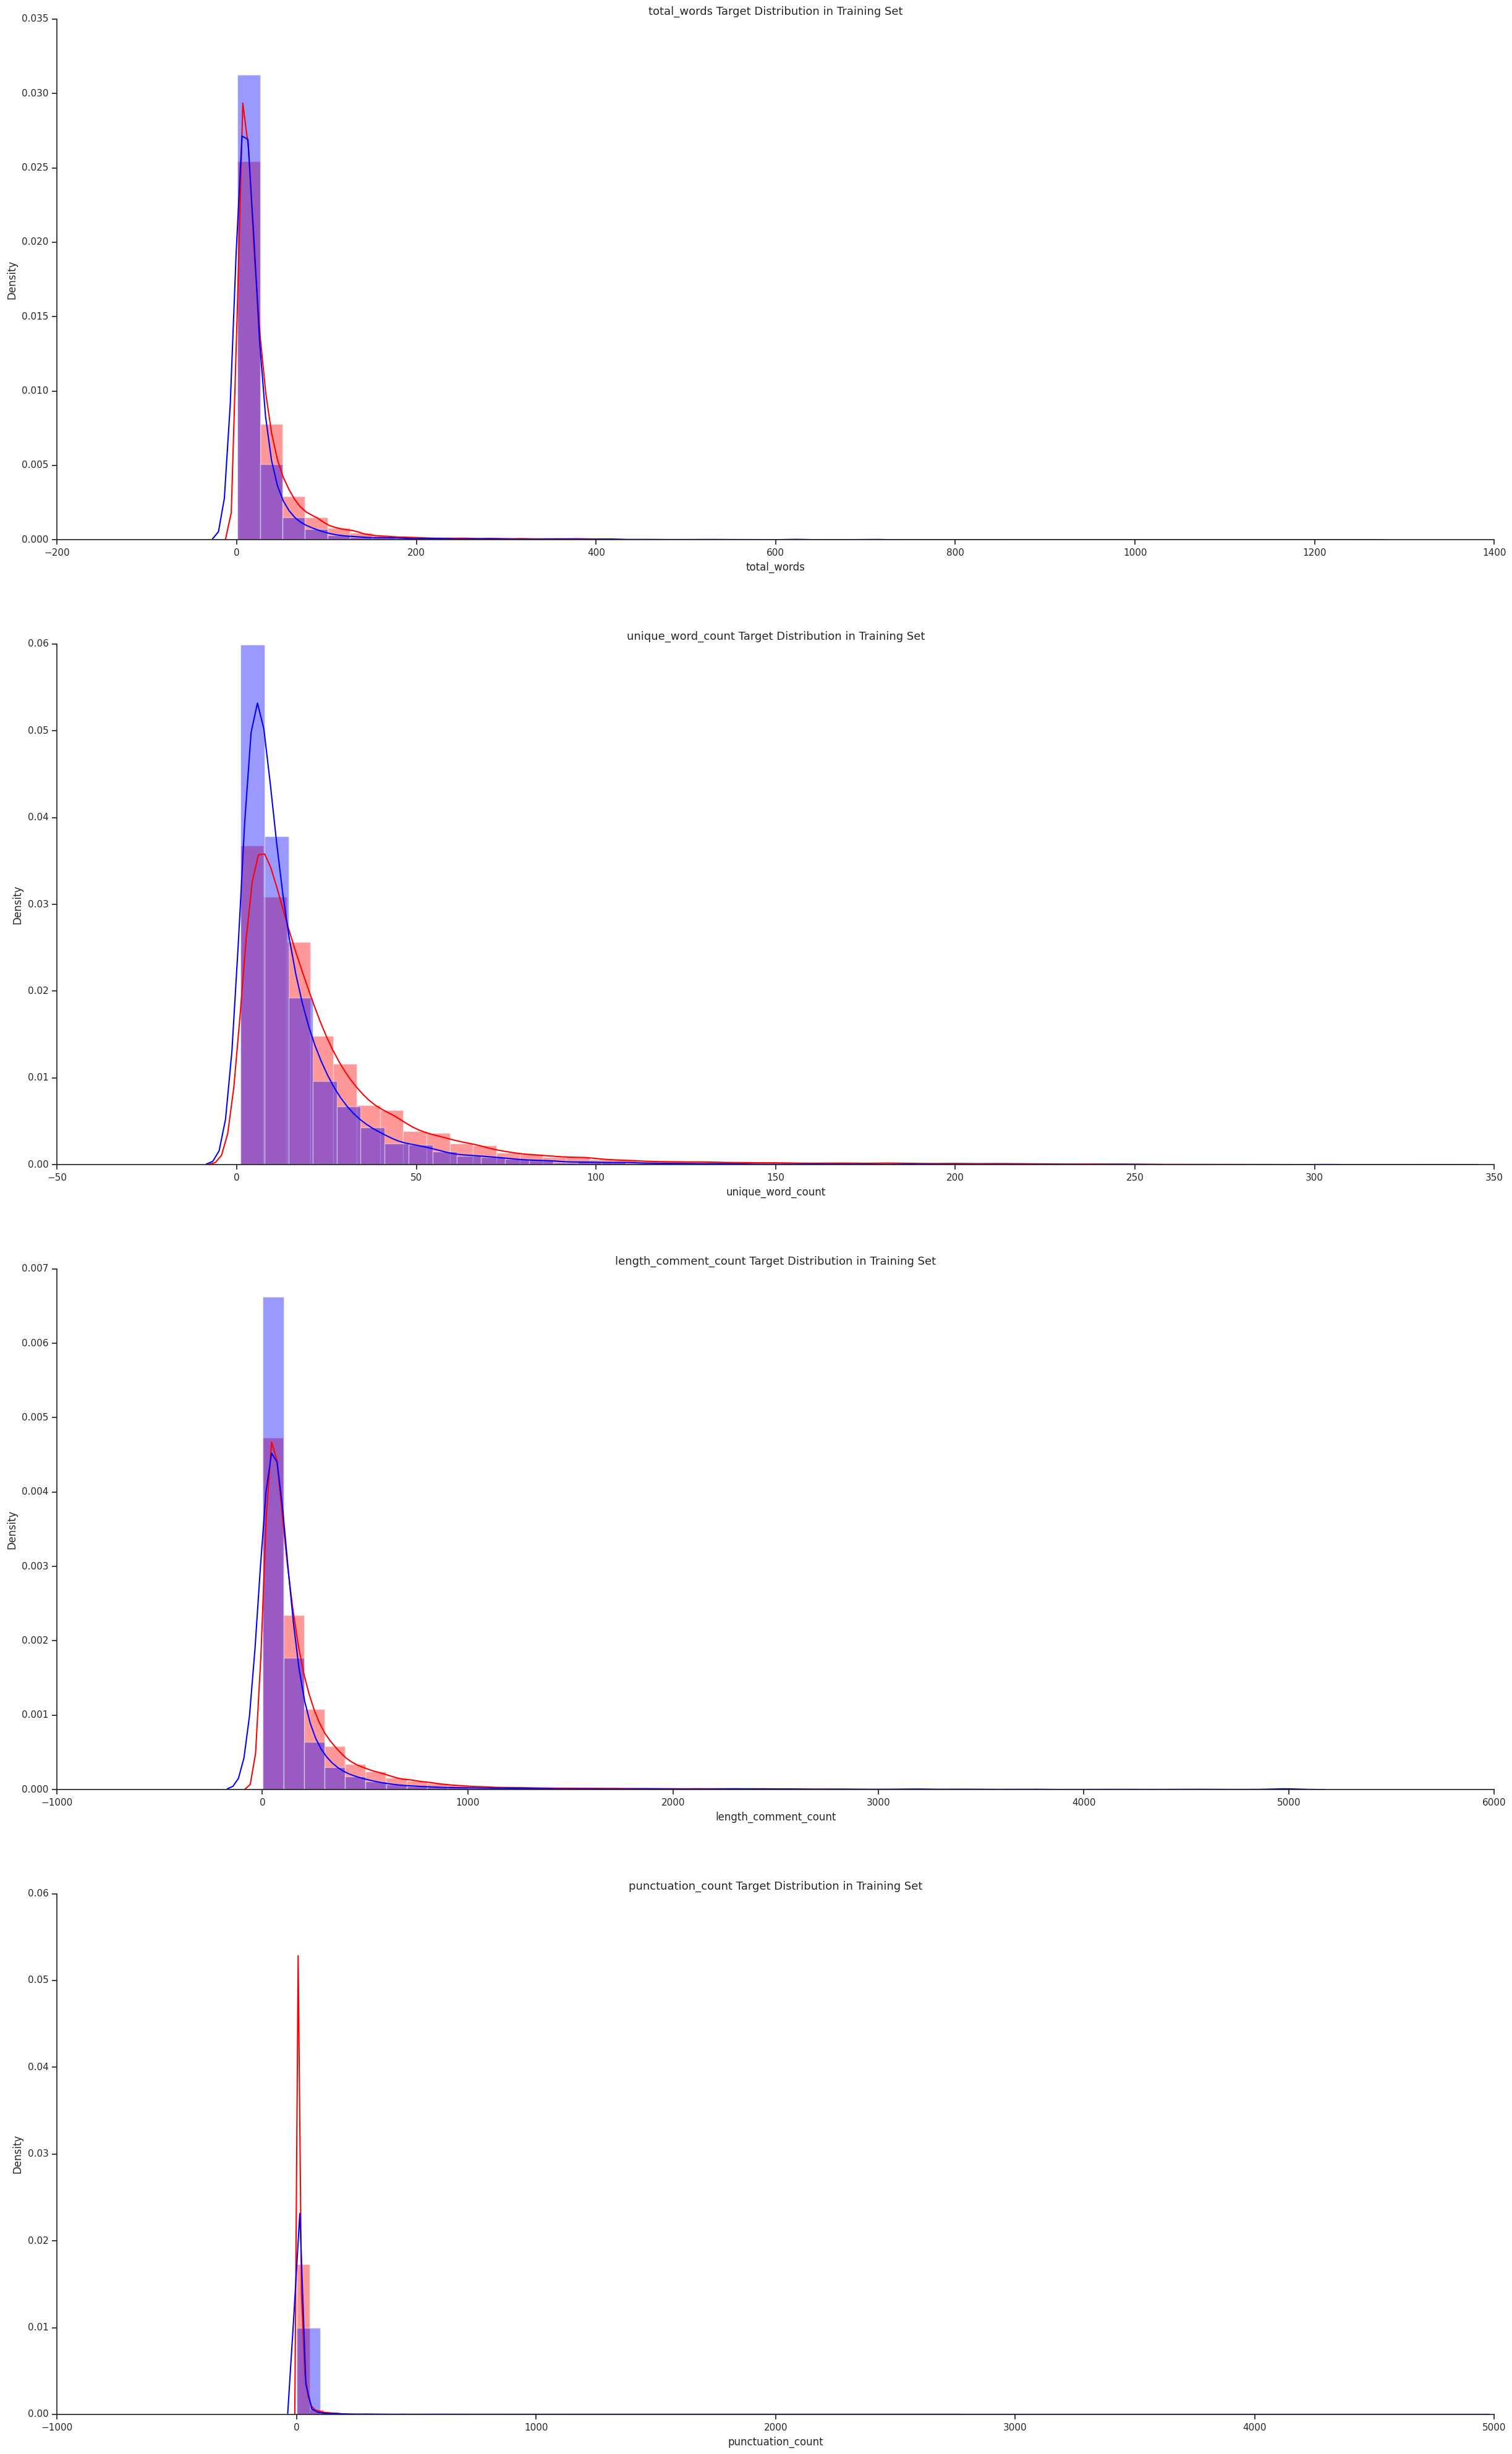

In [63]:
compare_using_plot(final_data_cleaned,'toxic')

## Distplot for Severe Toxic & Non Toxic Comments

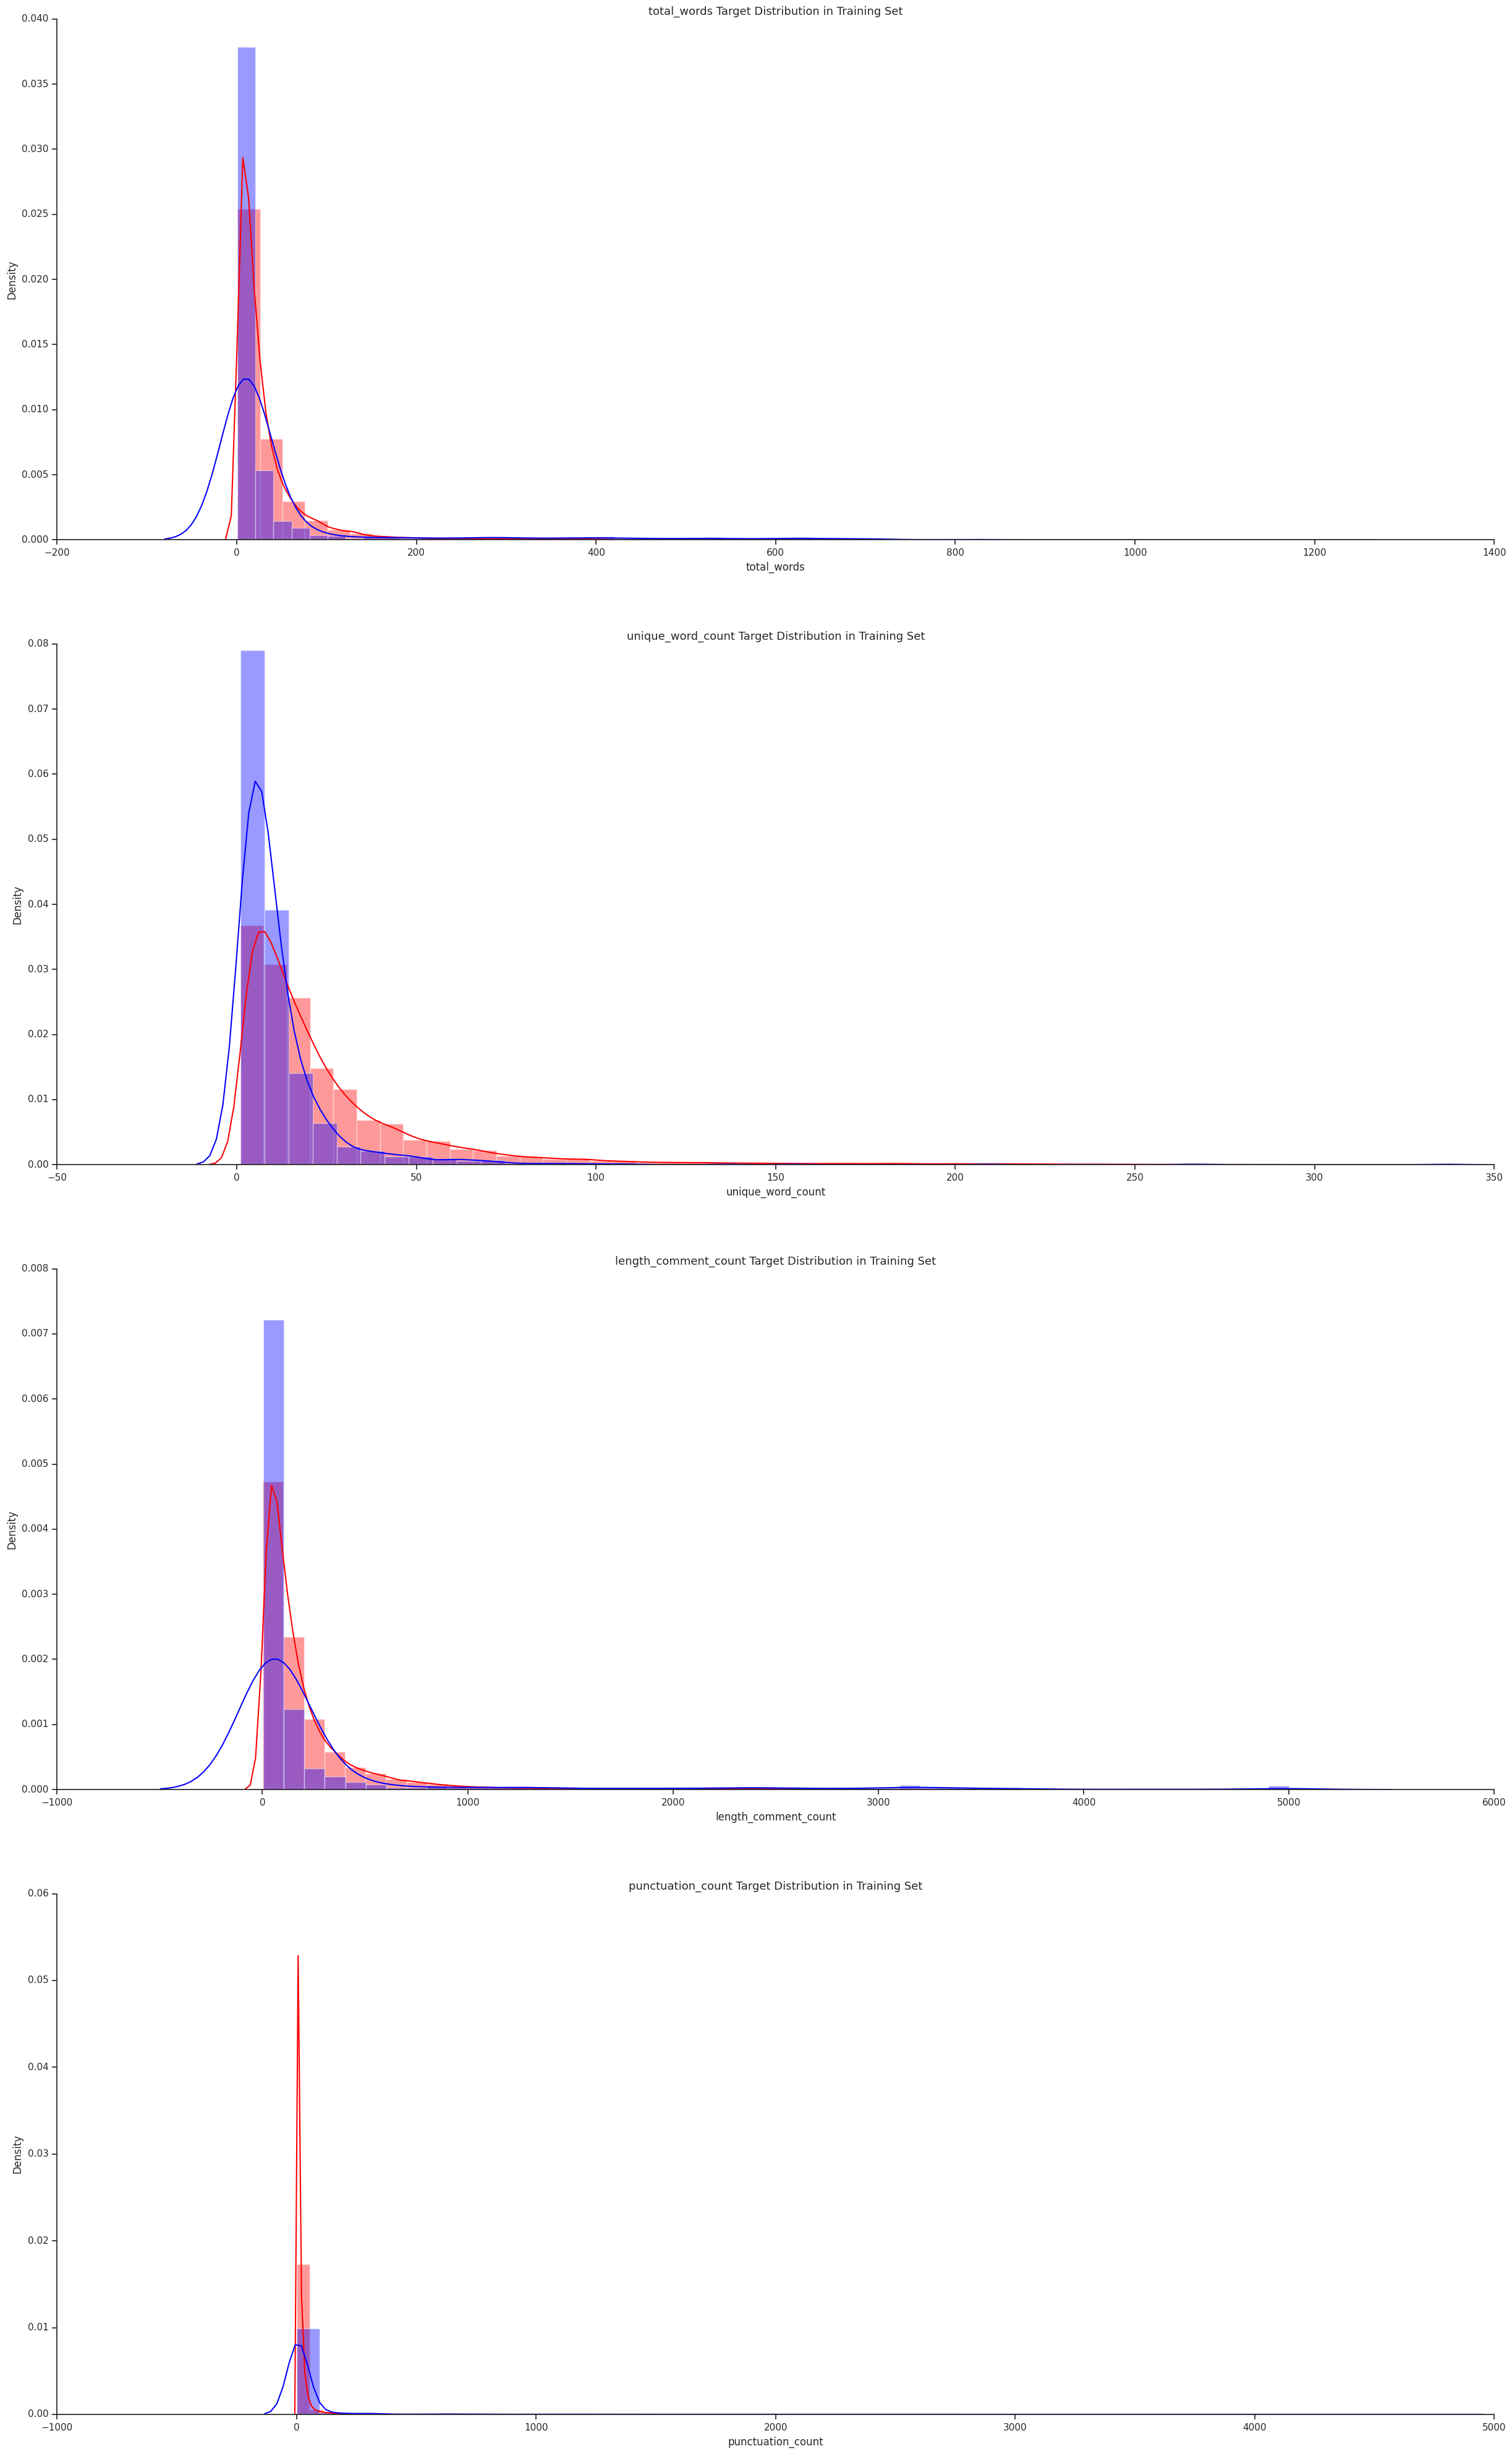

In [64]:
compare_using_plot(final_data_cleaned,'severe_toxic')

## Displot for Obscene and Non Toxic 

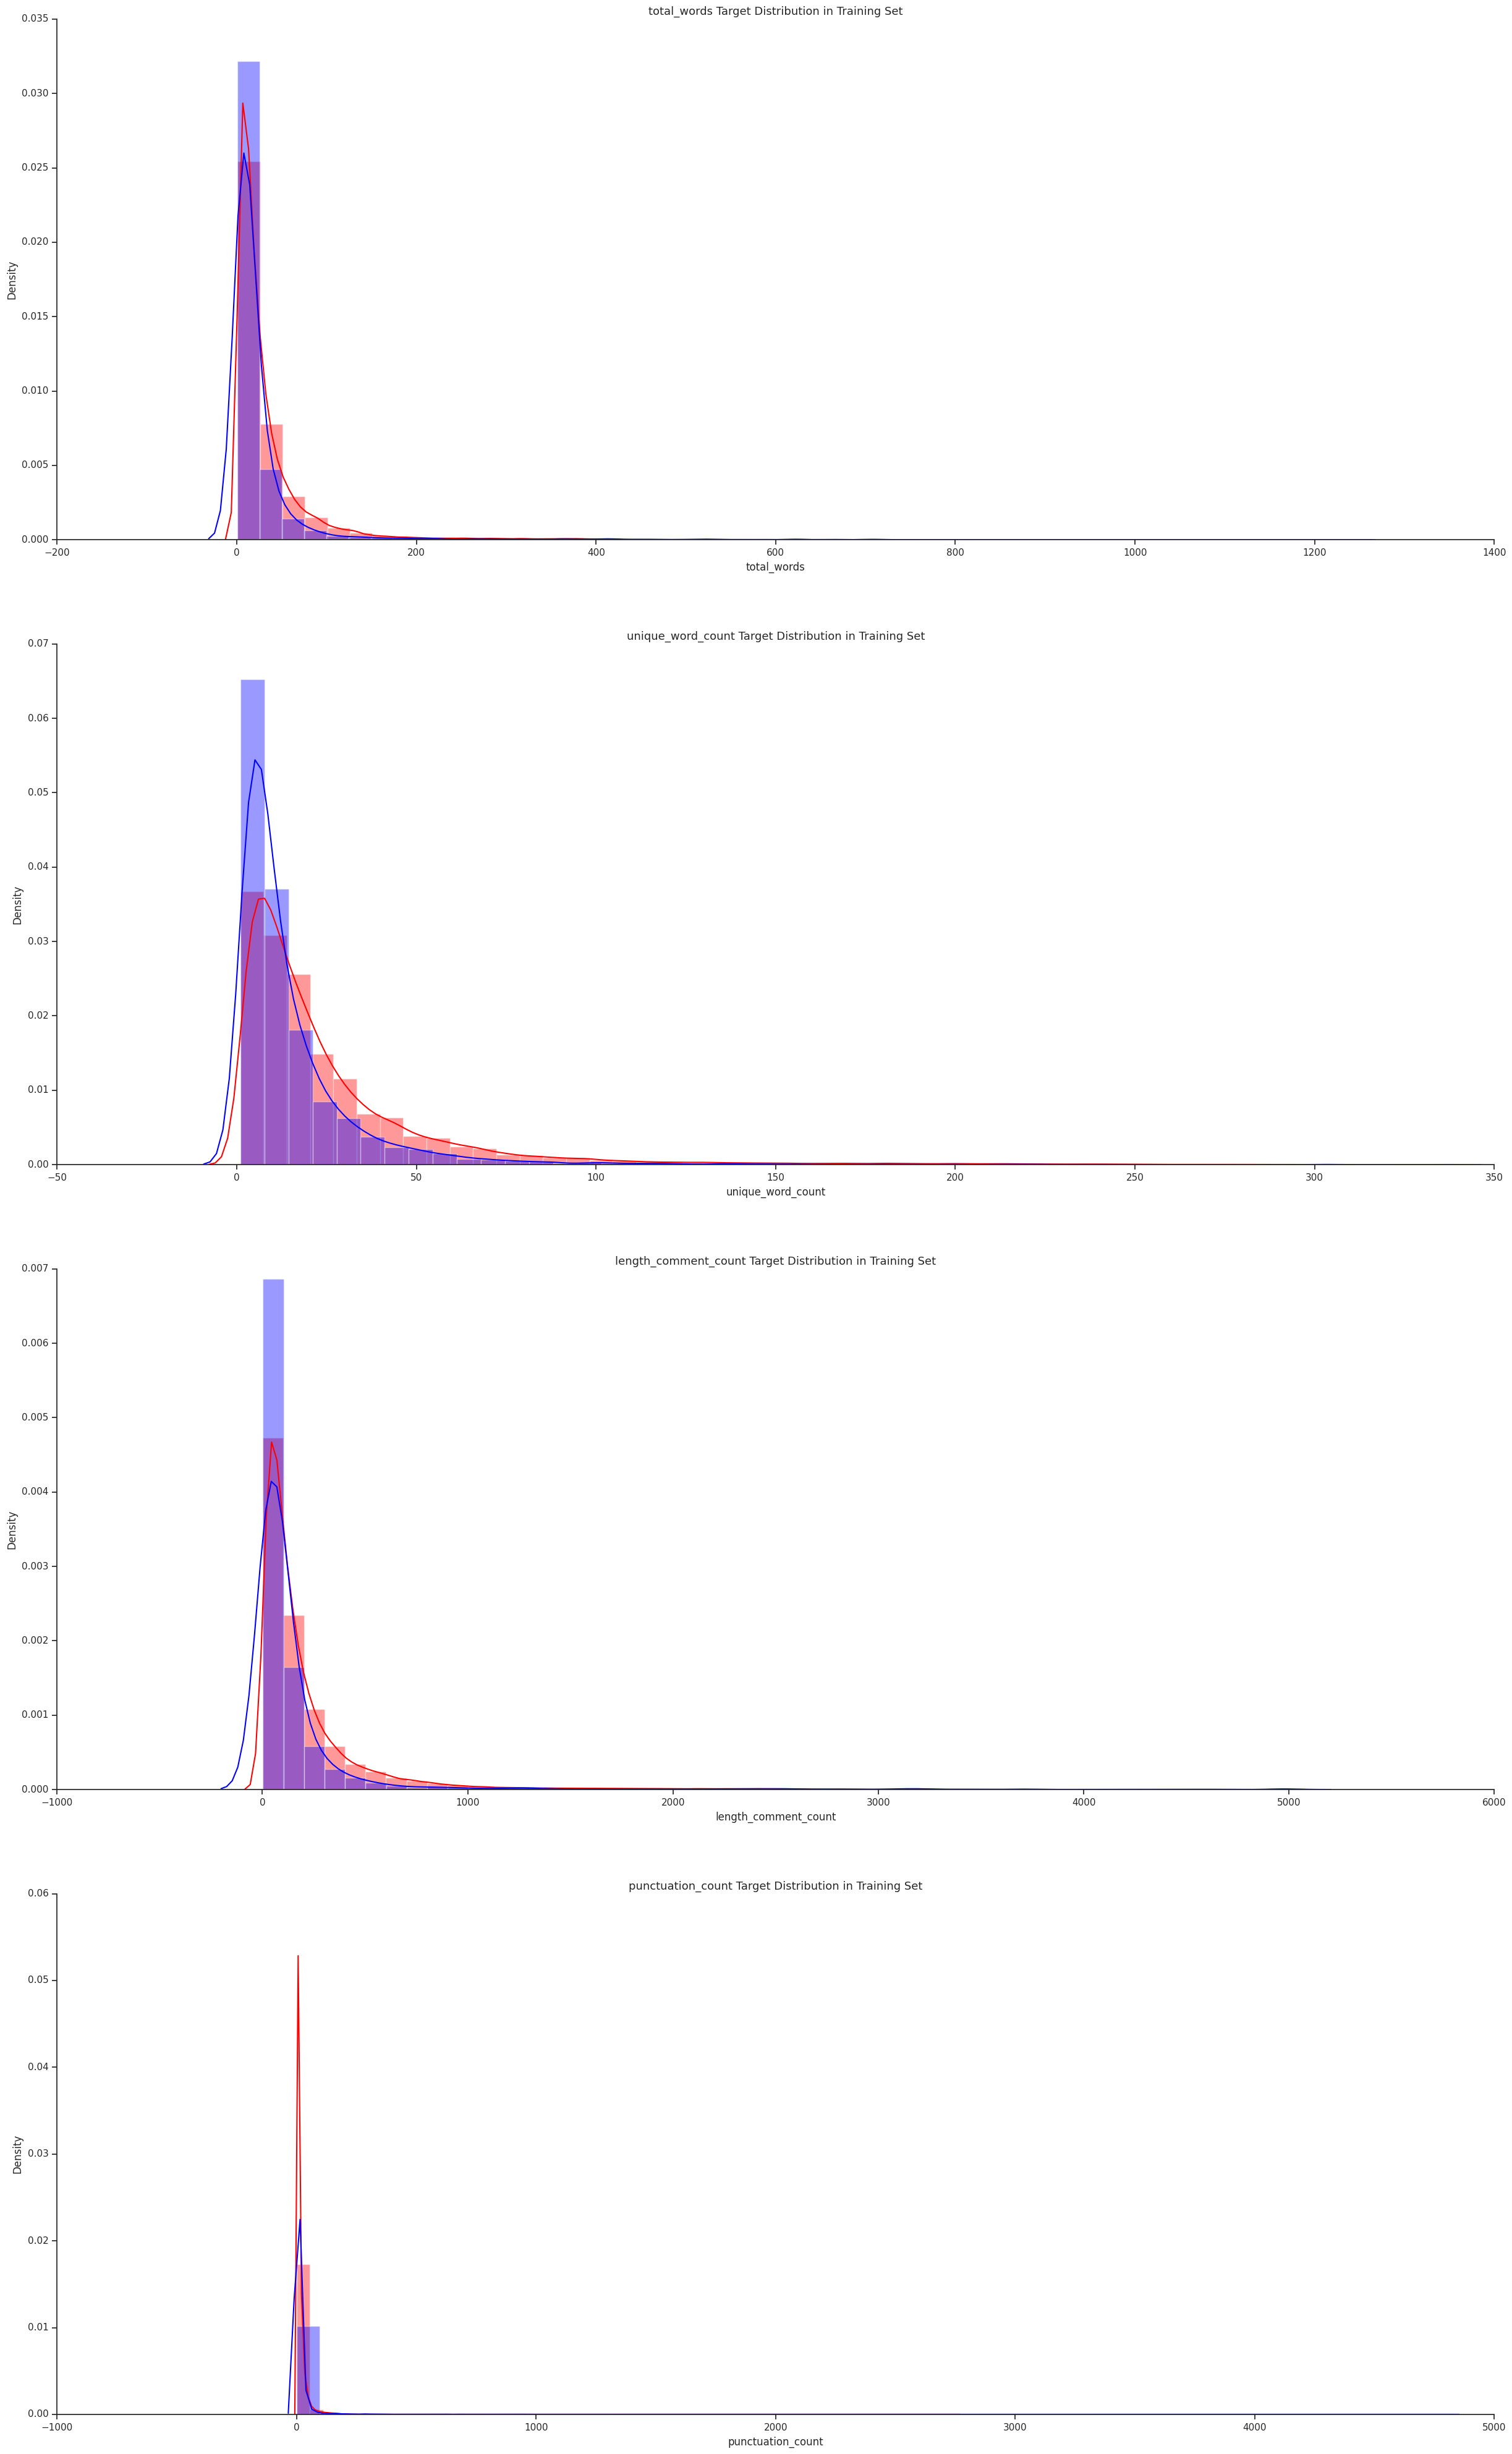

In [65]:
compare_using_plot(final_data_cleaned,'obscene')

## Displot for Threat and Non Toxic Comments

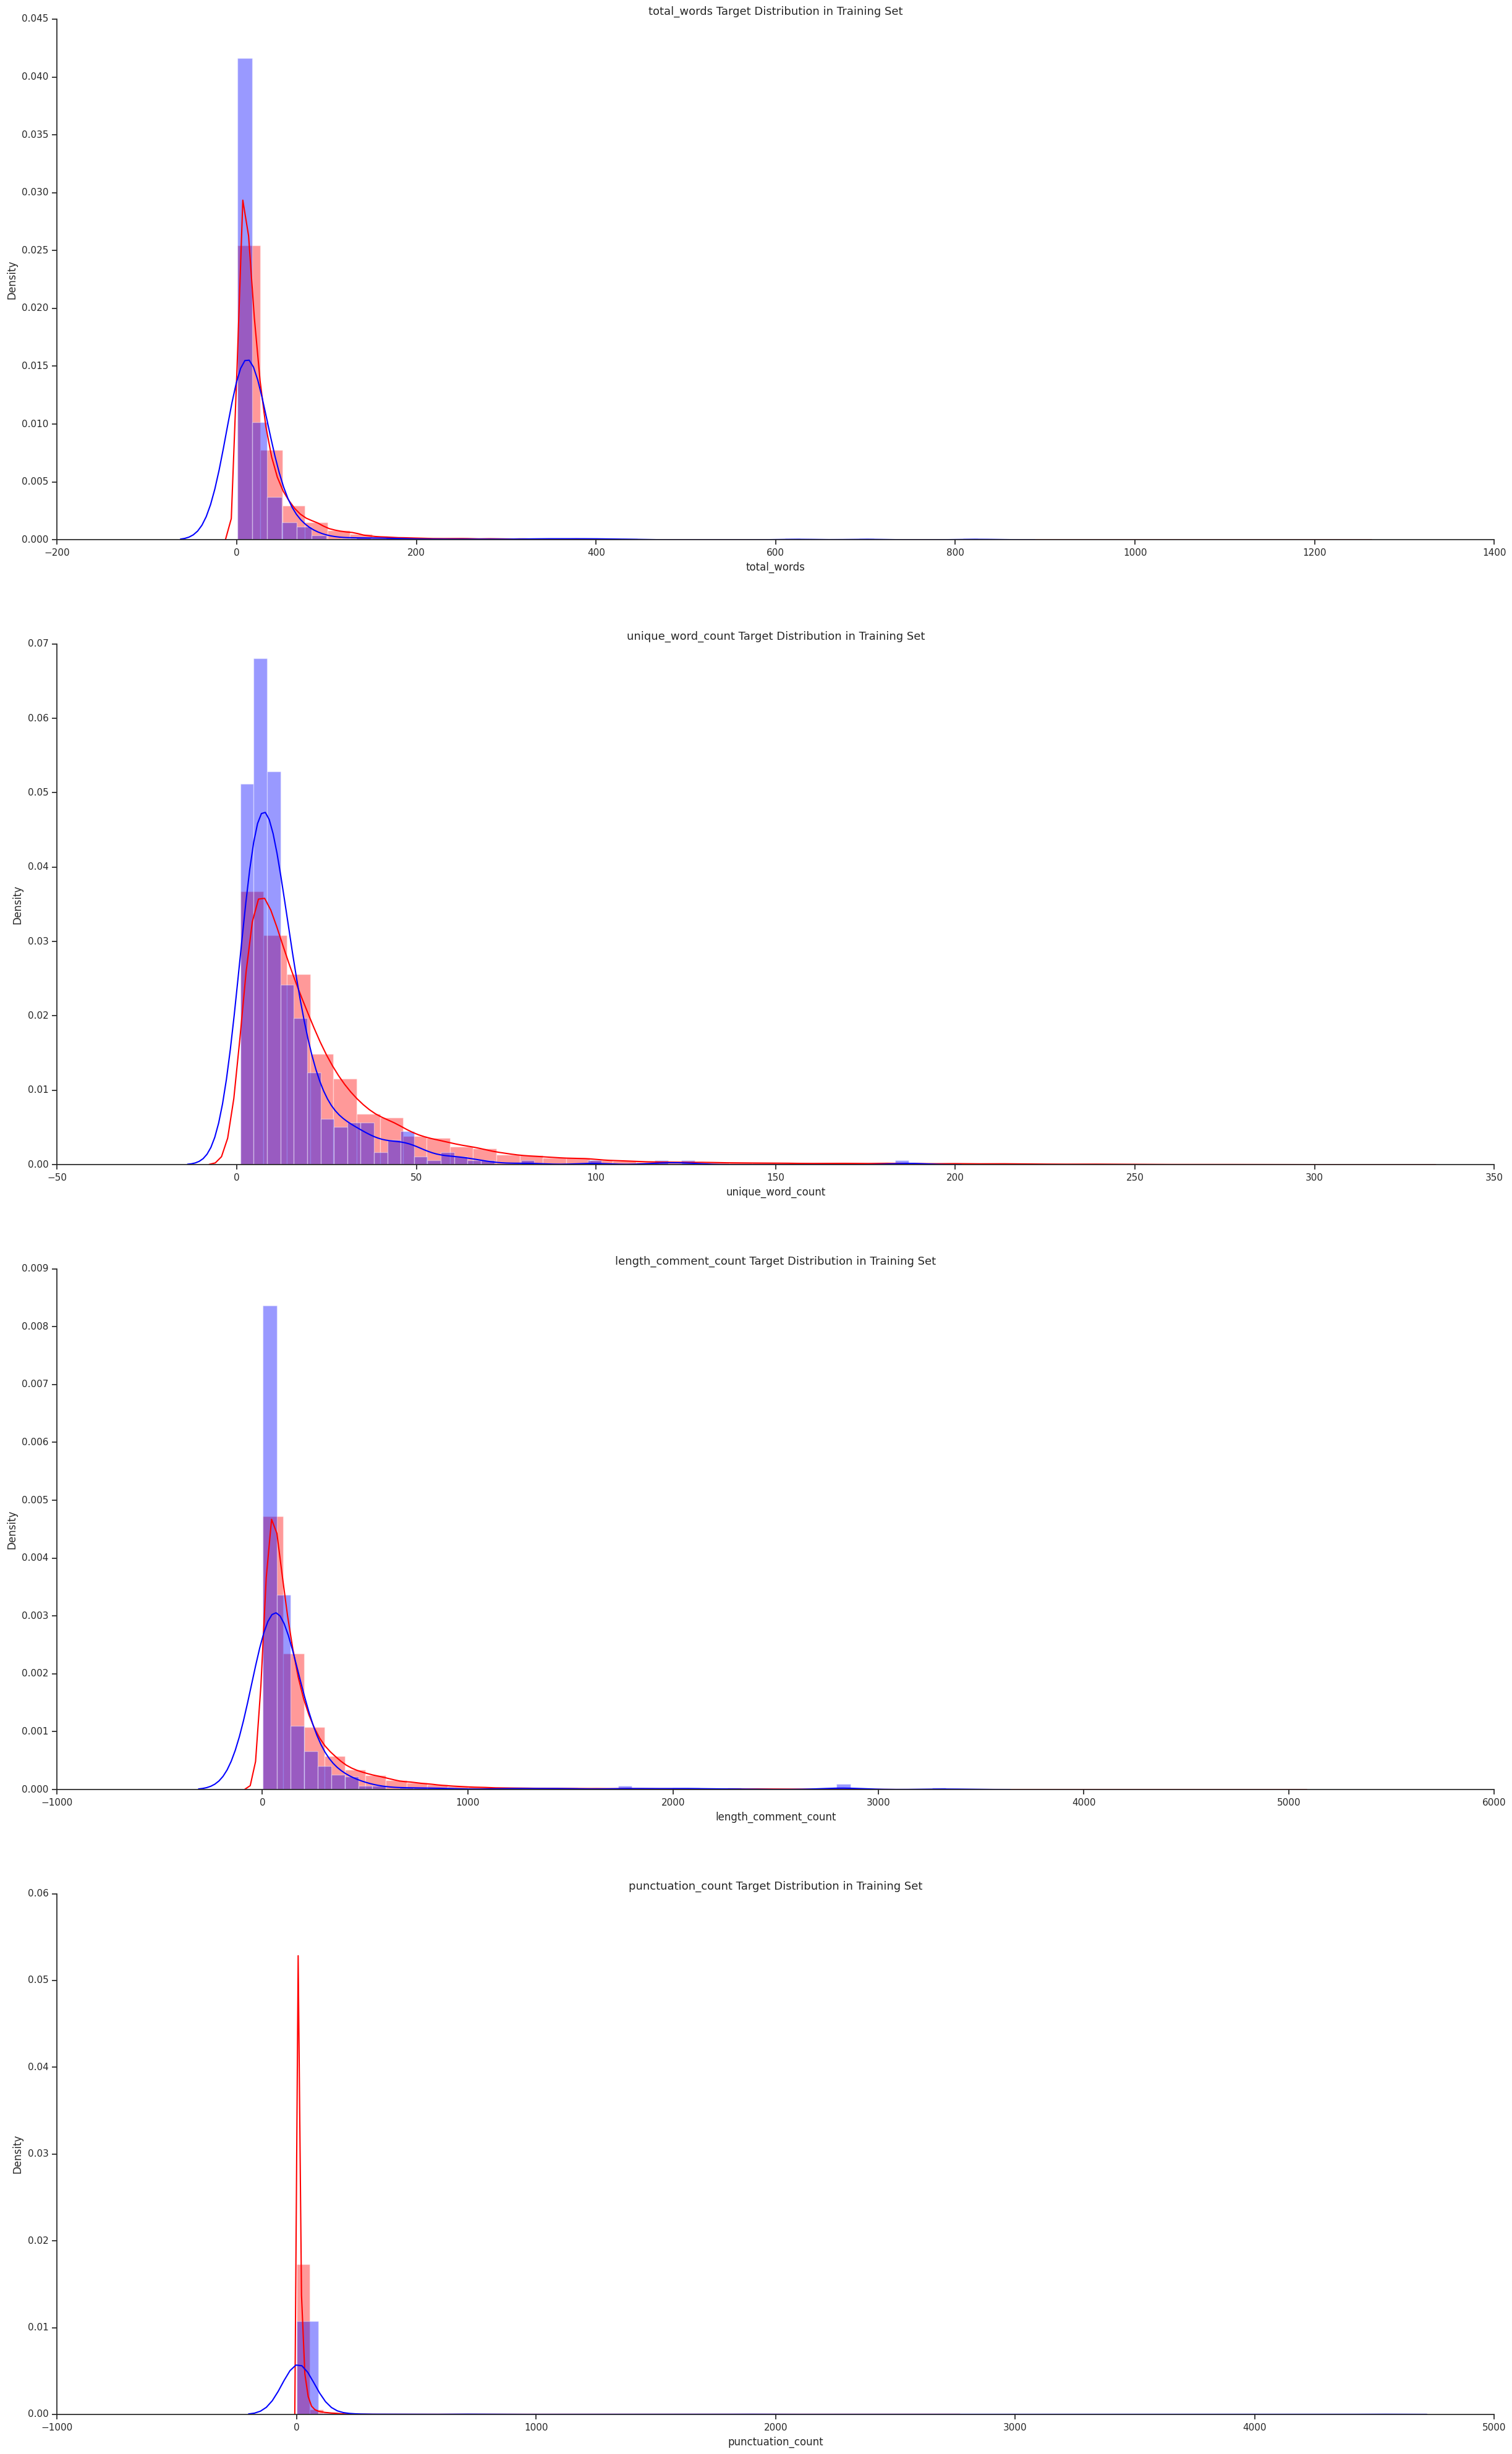

In [66]:
compare_using_plot(final_data_cleaned,'threat')

## Displot for Insult and Non Toxic Comments

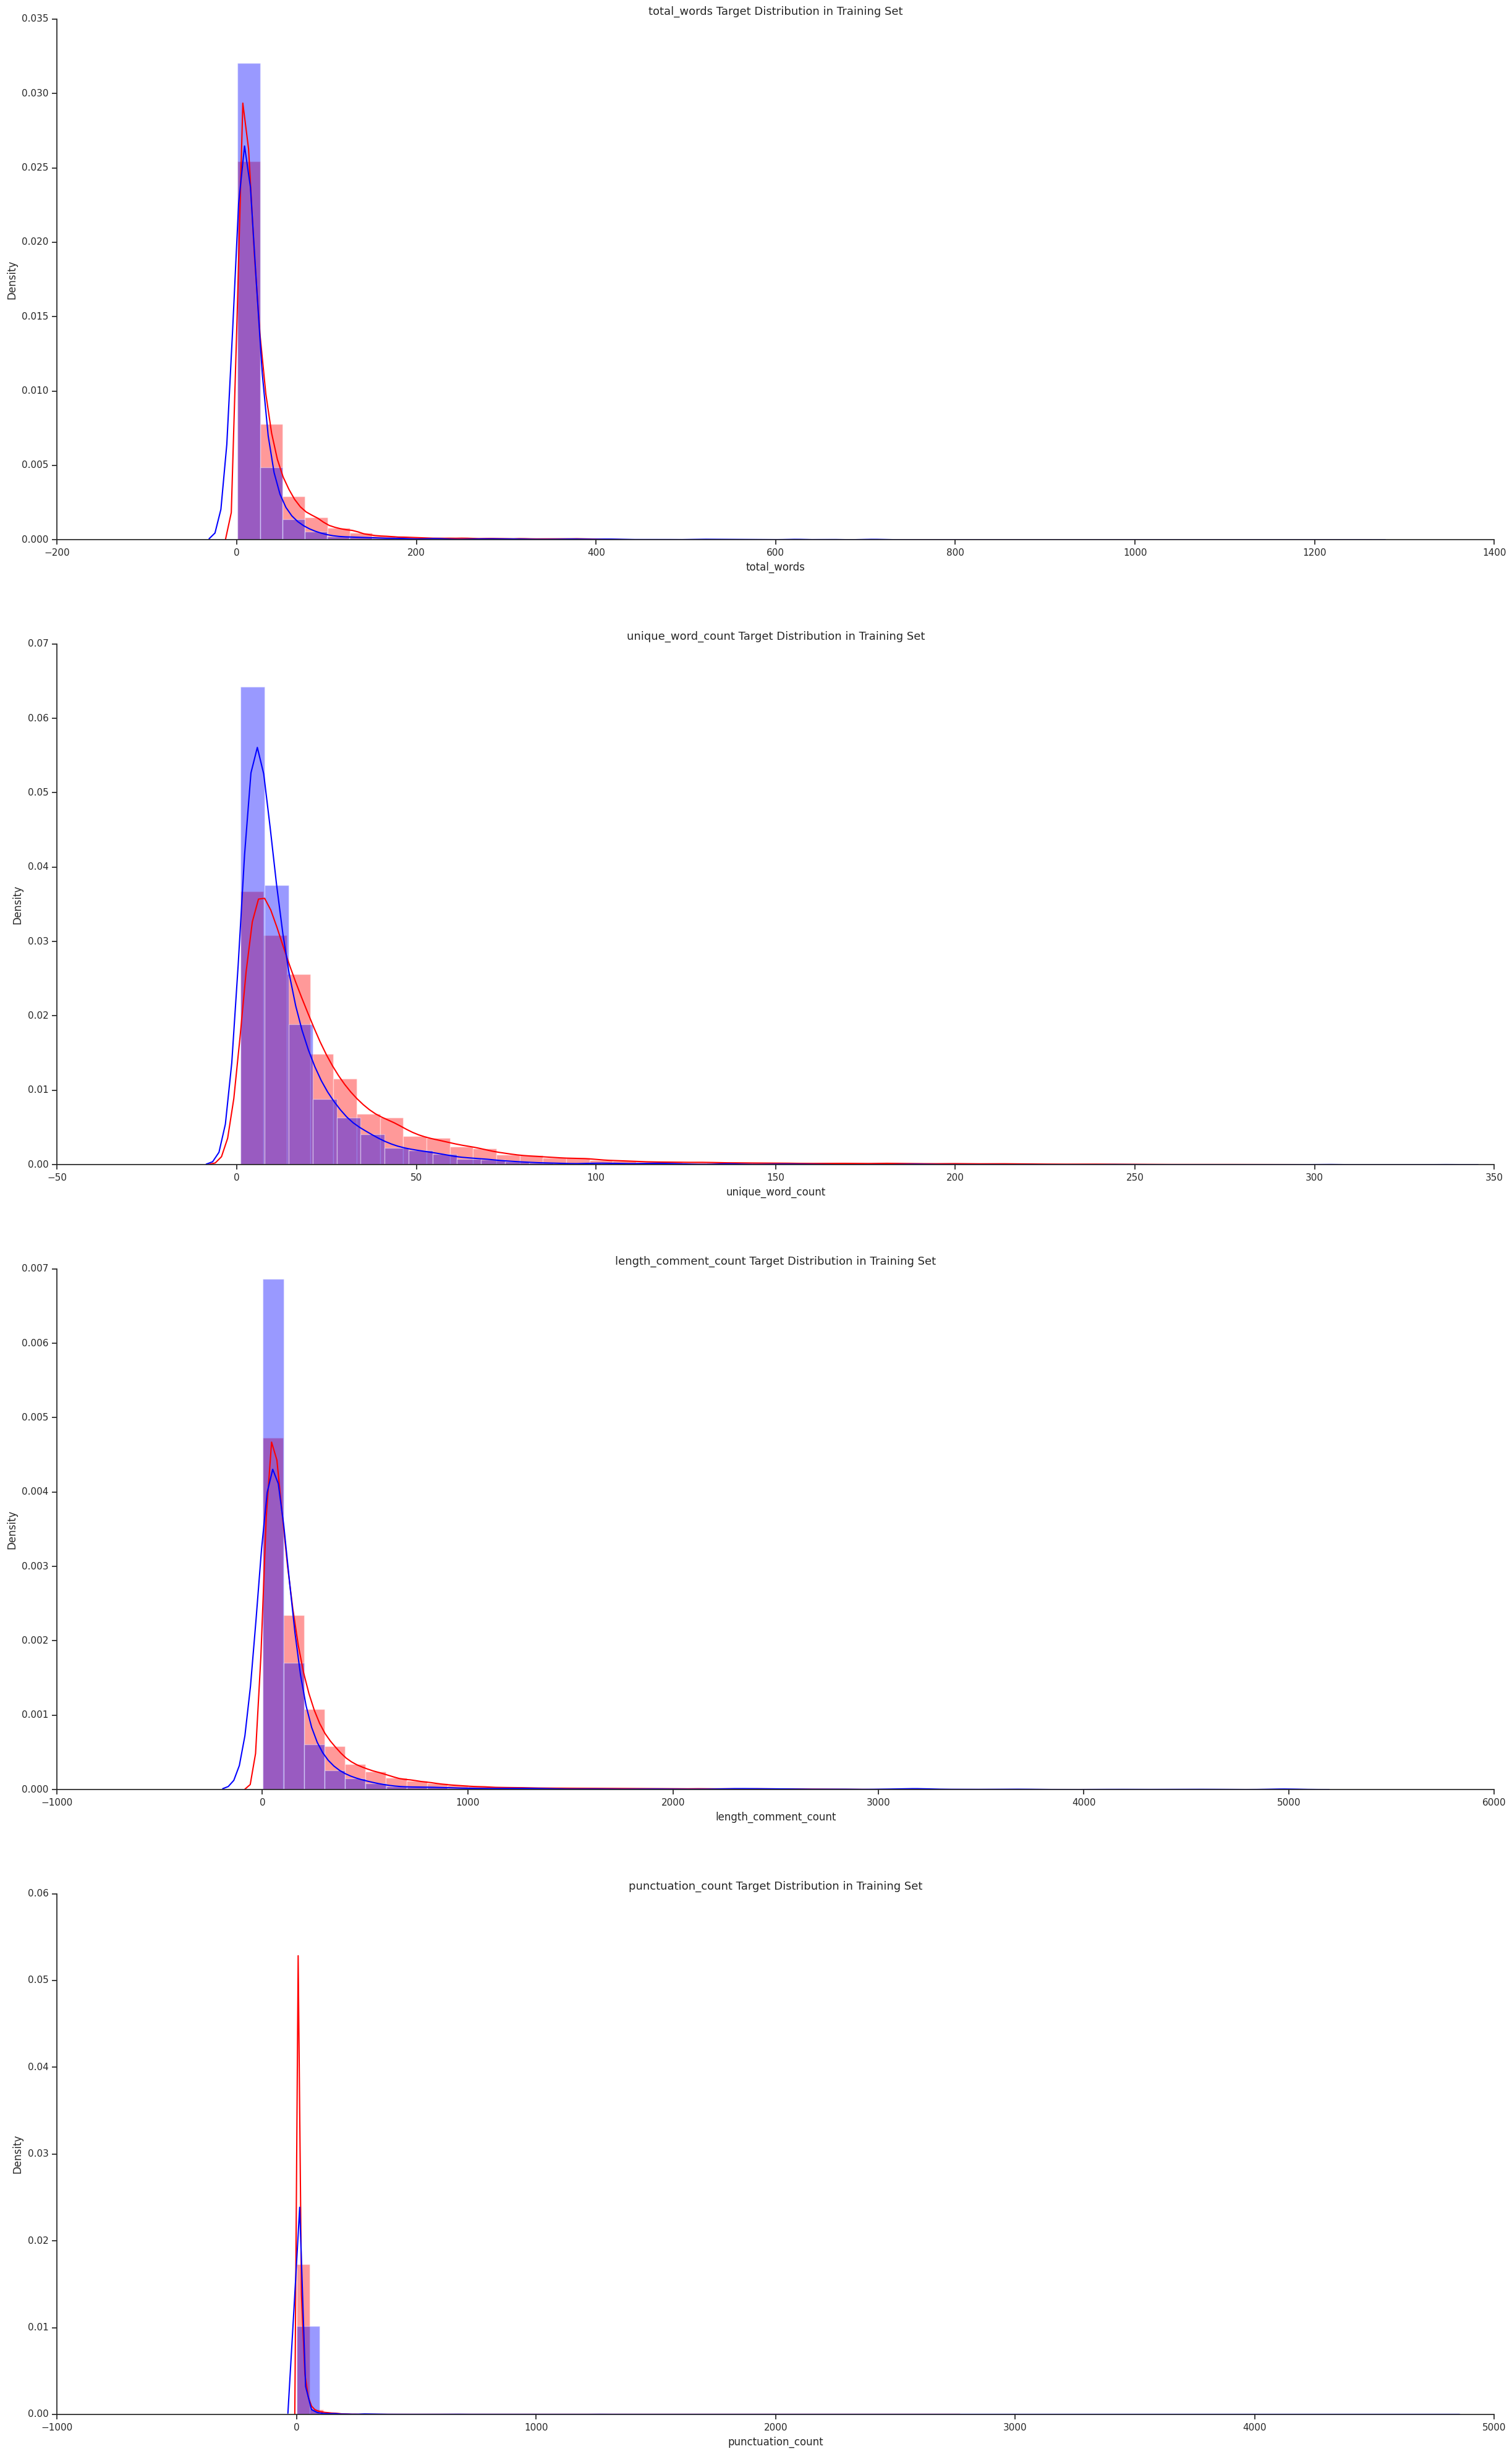

In [67]:
compare_using_plot(final_data_cleaned,'insult')

## Distplot for Toxic and Non Toxic Comments

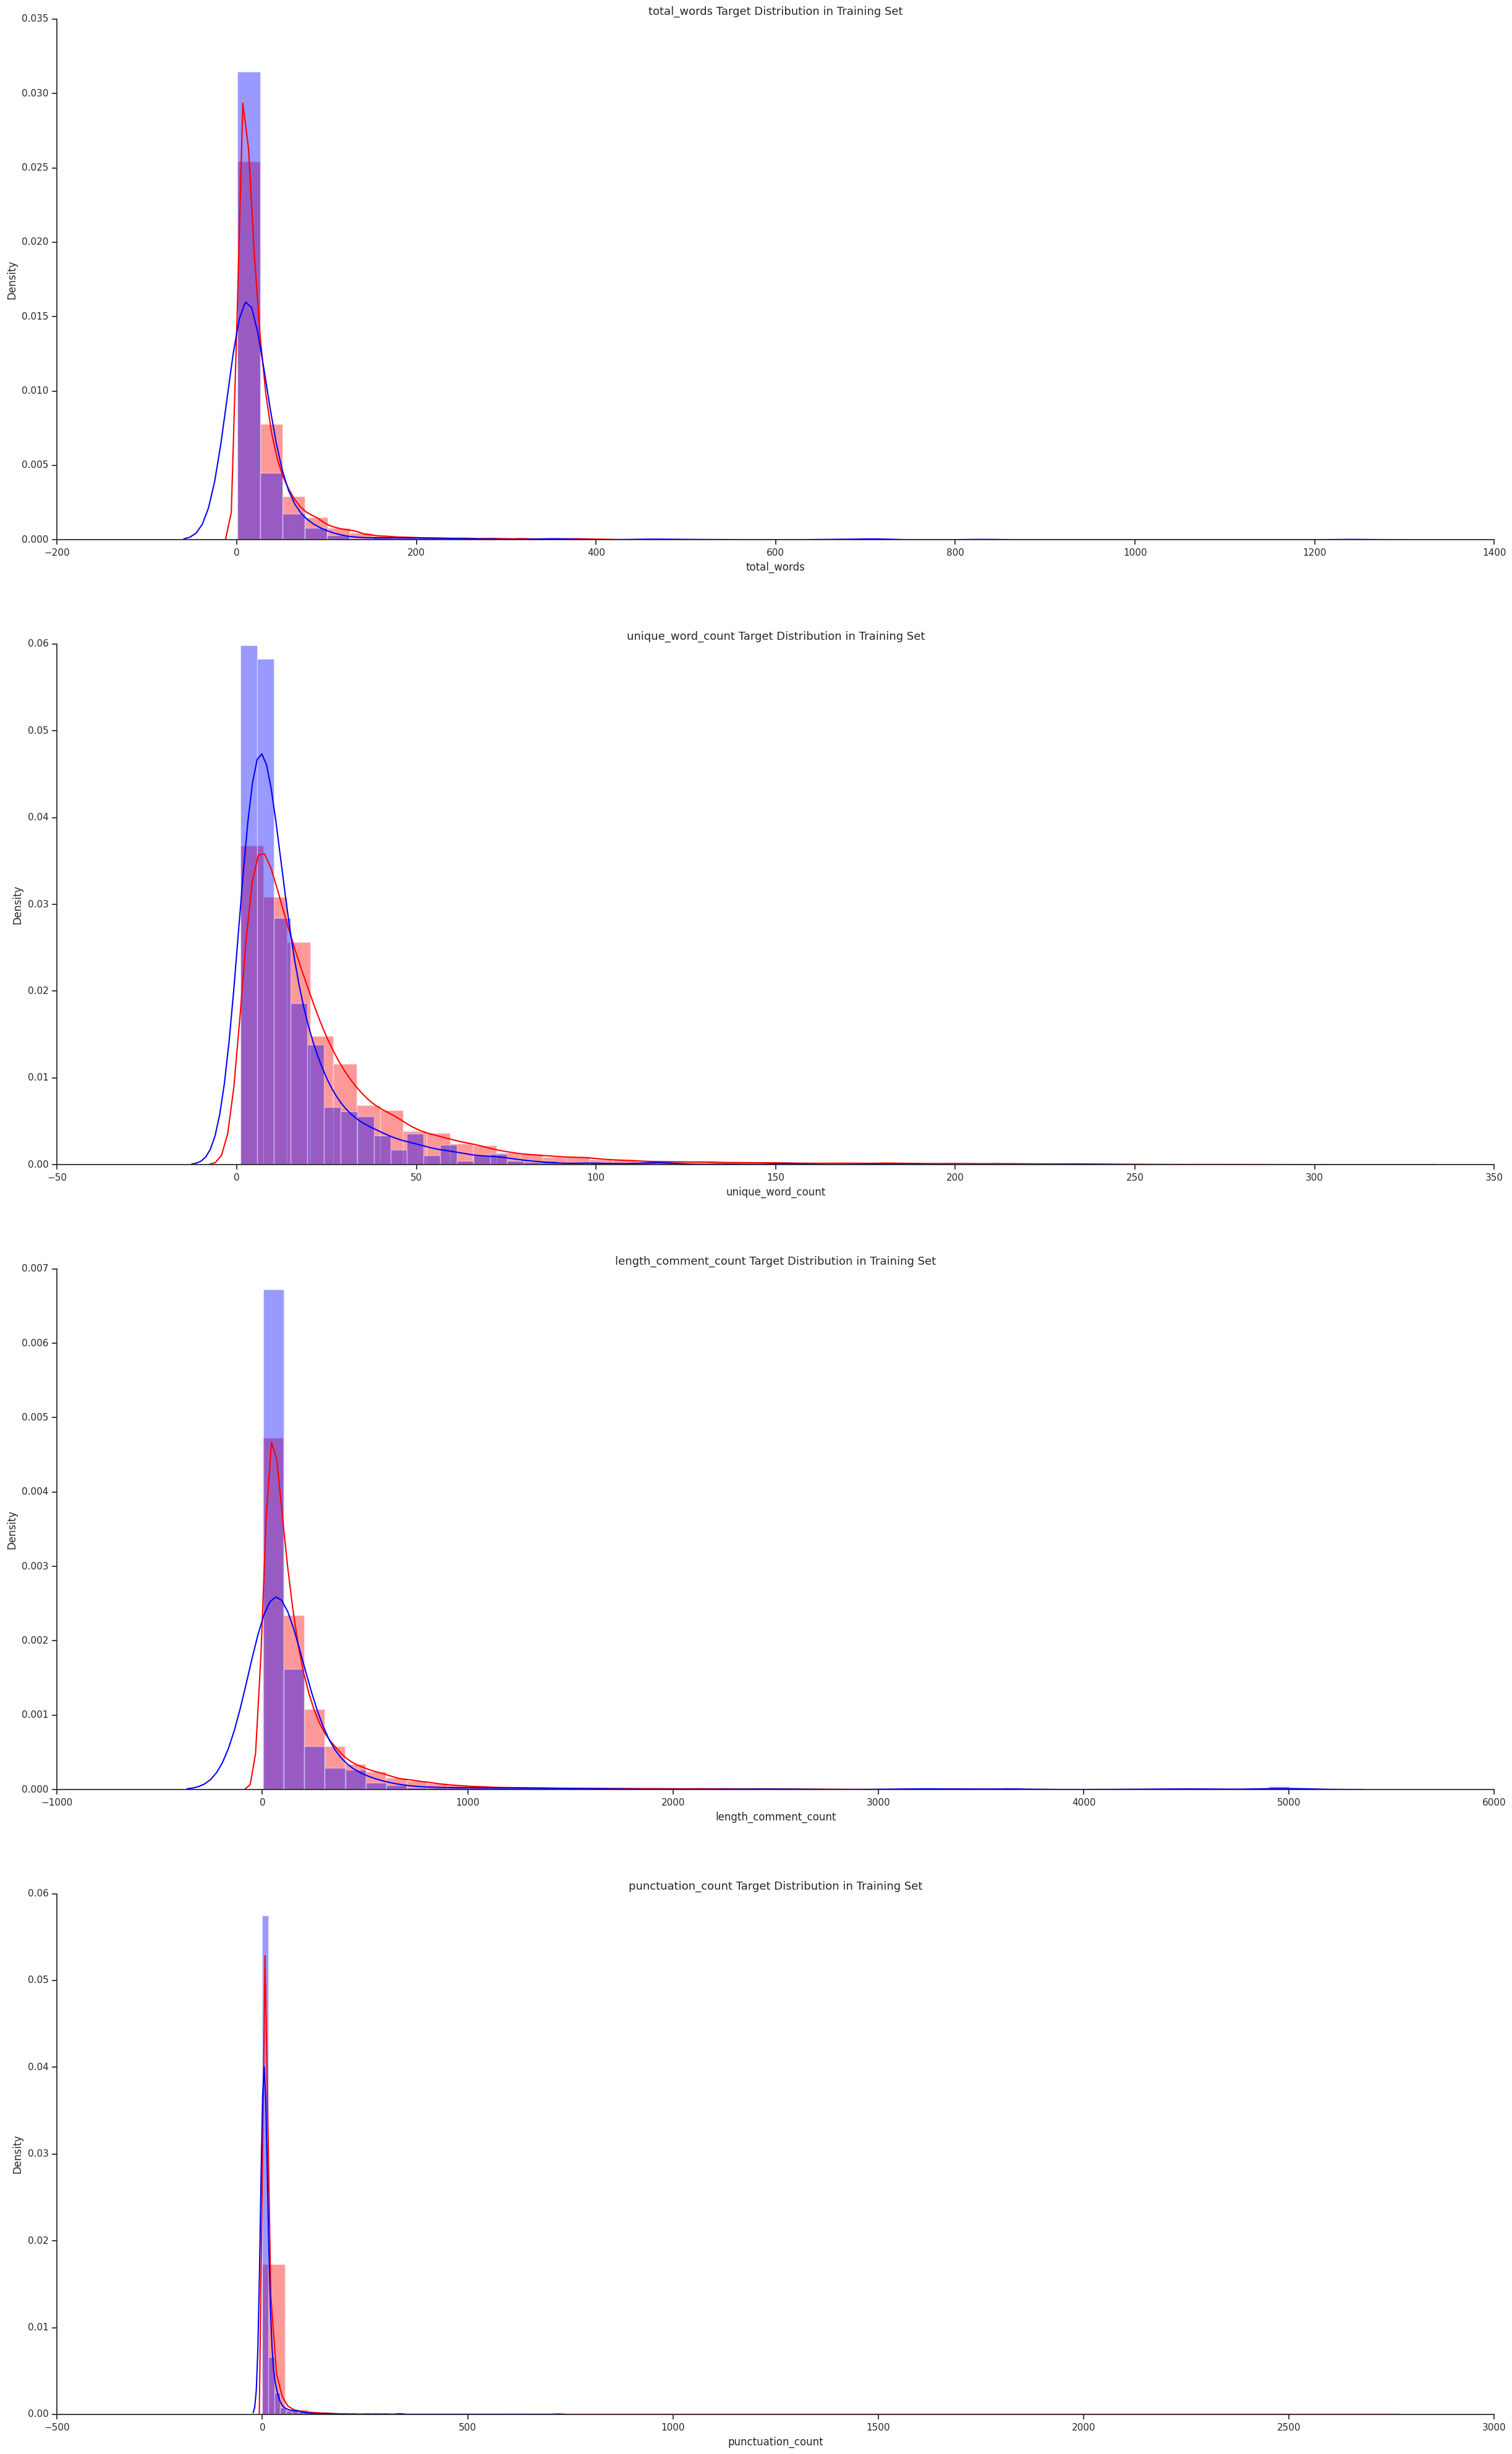

In [68]:
compare_using_plot(final_data_cleaned,'identity_hate')

In [69]:
final_data_cleaned.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,total_words,length_comment_count,unique_word_count,punctuation_count,y
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...,23,135,23,10,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stuck thank t...,10,61,10,12,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constant remov...,21,116,19,6,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...,45,272,39,21,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page,5,26,5,5,0


In [70]:
final_data_with_y = final_data_cleaned[['cleaned_text','toxic','severe_toxic','obscene','threat','insult','identity_hate','total_words','length_comment_count','unique_word_count','punctuation_count','y']]
final_data_with_y.head()

,cleaned_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_words,length_comment_count,unique_word_count,punctuation_count,y
0,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0,23,135,23,10,0
1,aww match background colour seem stuck thank t...,0,0,0,0,0,0,10,61,10,12,0
2,hey man realli tri edit war guy constant remov...,0,0,0,0,0,0,21,116,19,6,0
3,make real suggest improv wonder section statis...,0,0,0,0,0,0,45,272,39,21,0
4,sir hero chanc rememb page,0,0,0,0,0,0,5,26,5,5,0


In [71]:
final_data_with_y['y'].value_counts()

0    143169
1      6359
3      4206
2      3475
4      1756
5       384
6        31
Name: y, dtype: int64

array([[<AxesSubplot:title={'center':'y'}>]], dtype=object)

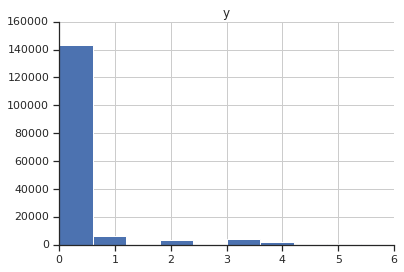

In [72]:
final_data_with_y.hist(column='y')

In [73]:
final_data = final_data_cleaned[['cleaned_text','toxic','severe_toxic','obscene','threat','insult','identity_hate','total_words','length_comment_count','unique_word_count','punctuation_count','y']]
final_data.head()

,cleaned_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_words,length_comment_count,unique_word_count,punctuation_count,y
0,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0,23,135,23,10,0
1,aww match background colour seem stuck thank t...,0,0,0,0,0,0,10,61,10,12,0
2,hey man realli tri edit war guy constant remov...,0,0,0,0,0,0,21,116,19,6,0
3,make real suggest improv wonder section statis...,0,0,0,0,0,0,45,272,39,21,0
4,sir hero chanc rememb page,0,0,0,0,0,0,5,26,5,5,0


# Data is Highly Imbalanced
## We will use Data Augmentation technique to solve the Imbalanced Dataset. Here we will use "synonym replacement" via Word Embedding using Glove. We will replace the n number of words with its synonym to obtain a sentence with the same meaning but with different words. We will use Minority Class Datapoints to generate more data, so that we can solve Data Imbalance problem. 
## NLPAug Python Library does that work for us. Soo Lets pip Install and import NLPAug Library. 

In [74]:
# model_type: word2vec, glove or fasttext
aug_w2v = naw.WordEmbsAug(model_type='glove', model_path='../input/glove-pretrained/glove.6B.100d.txt',action="substitute")

In [75]:
# This Operation has the ability to augment the data using "synonym replacement - glove technique"
def easy_data_augmentation(df,samples,toxic_label,pr):
    
    
    """
    This Operation has the ability to augment the data using "synonym replacement - glove technique"
    
    Parameters : 
    df (Dataframe) : Contains the Dataframe
    sample : How many Samples we need to augment
    toxic_label : Which type of label we want to have data augment
    pr : percentage of data needs to augment
    
    """
    aug_w2v.aug_p=pr
    new_text = []
        
    
    if(toxic_label==1):
        df_new=df[df.y==1]
    elif(toxic_label==2):
        df_new=df[df.y==2]
    elif(toxic_label==3):
        df_new=df[df.y==3]
    elif(toxic_label==4):
        df_new=df[df.y==4]
    elif(toxic_label==5):
        df_new=df[df.y==5]
    elif(toxic_label==6):
        df_new=df[df.y==6]
    
    
    for j in tqdm(np.random.randint(0,len(df_new),samples)):
        text=df_new.iloc[j]['cleaned_text']
        aug_text=aug_w2v.augment(text)
        new_text.append(aug_text)
        
    
    new_df = pd.DataFrame({'cleaned_text':new_text,'y':toxic_label})
    df=shuffle(df.append(new_df).reset_index(drop=True))
    return df

In [76]:
final_data_with_data_aug=easy_data_augmentation(final_data,6359,1,0.3)

100%|██████████| 6359/6359 [17:53<00:00,  5.92it/s]  


In [77]:
final_data_with_data_aug=easy_data_augmentation(final_data_with_data_aug,4206,3,0.3)

100%|██████████| 4206/4206 [09:43<00:00,  7.21it/s]


In [78]:
final_data_with_data_aug=easy_data_augmentation(final_data_with_data_aug,3475,2,0.3)

100%|██████████| 3475/3475 [07:43<00:00,  7.50it/s]


In [79]:
final_data_with_data_aug=easy_data_augmentation(final_data_with_data_aug,1756,4,0.3)

100%|██████████| 1756/1756 [04:23<00:00,  6.67it/s]


In [80]:
final_data_with_data_aug=easy_data_augmentation(final_data_with_data_aug,384,5,0.3)

100%|██████████| 384/384 [00:54<00:00,  7.10it/s]


In [81]:
final_data_with_data_aug=easy_data_augmentation(final_data_with_data_aug,31,6,0.3)

100%|██████████| 31/31 [00:05<00:00,  5.46it/s]


In [82]:
final_data_with_data_aug.to_csv('final_data_with_data_aug.csv')

In [83]:
final_train_data = pd.read_csv('../input/augmented-data/final_data_with_data_aug.csv')
print('Number of Data Points :',final_train_data.shape[0])
print('Number of Features :',final_train_data.shape[1])
print ('Features :',final_train_data.columns.values)

final_train_data.head()

Number of Data Points : 175591
Number of Features : 13
Features : ['Unnamed: 0' 'cleaned_text' 'toxic' 'severe_toxic' 'obscene' 'threat'
 'insult' 'identity_hate' 'total_words' 'length_comment_count'
 'unique_word_count' 'punctuation_count' 'y']


,Unnamed: 0,cleaned_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_words,length_comment_count,unique_word_count,punctuation_count,y
0,76708,complet support qaeda jihadist group qaeda lea...,0.0,0.0,0.0,0.0,0.0,0.0,49.0,319.0,38.0,12.0,0
1,56210,pictur taken comic book valuabl art work europ...,0.0,0.0,0.0,0.0,0.0,0.0,15.0,96.0,15.0,9.0,0
2,24771,use british isl,0.0,0.0,0.0,0.0,0.0,0.0,3.0,15.0,3.0,0.0,0
3,32373,yea boi hello took away edit victor cruz said ...,1.0,0.0,0.0,0.0,0.0,0.0,30.0,166.0,25.0,14.0,1
4,88820,respons doubt citat base fact fact associ cita...,0.0,0.0,0.0,0.0,0.0,0.0,79.0,532.0,56.0,37.0,0


In [84]:
final_train_data['y'].value_counts()

0    143169
1     12718
3      8412
2      6950
4      3512
5       768
6        62
Name: y, dtype: int64

array([[<AxesSubplot:title={'center':'y'}>]], dtype=object)

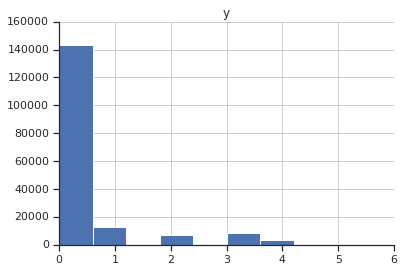

In [85]:
final_train_data.hist(column='y')

In [86]:
final_train_data=final_train_data.drop(['Unnamed: 0'],axis=1)
final_train_data.shape

(175591, 12)

## Now Lets Work to Preprocess Test Dataset

In [87]:
test_data = test_data_combined

In [88]:
test_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0,0,0,0,0,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,0,0,0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,0,0,0,0,0


In [89]:
final_test_data=cleaned_text_data(test_data)

100%|██████████| 153164/153164 [01:30<00:00, 1697.21it/s]


In [90]:
final_test_data.to_csv("final_test_data.csv")
final_test_data.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0,0,0,0,0,0,bitch rule succes ever what hate sad mofucka b...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0,rfc titl fine imo
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0,sourc zaw ashton lapland


In [91]:
final_test_data.drop(['comment_text','id'],axis=1,inplace=True)

In [92]:
print('Number of Data Points :',final_test_data.shape[0])
print('Number of Features :',final_test_data.shape[1])
print ('Features :',final_test_data.columns.values)

final_test_data.head()

Number of Data Points : 153164
Number of Features : 7
Features : ['toxic' 'severe_toxic' 'obscene' 'threat' 'insult' 'identity_hate'
 'cleaned_text']


,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text
0,0,0,0,0,0,0,bitch rule succes ever what hate sad mofucka b...
1,0,0,0,0,0,0,rfc titl fine imo
2,0,0,0,0,0,0,sourc zaw ashton lapland
3,0,0,0,0,0,0,look back sourc inform updat correct form gues...
4,0,0,0,0,0,0,anonym edit articl


In [93]:
x_train = final_train_data[['cleaned_text','total_words','length_comment_count','unique_word_count','punctuation_count']]
y_train = final_train_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

In [94]:
x_test = final_test_data['cleaned_text']
y_test = final_test_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

## By using TF-IDF Vectorization Technique 

In [95]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print("="*100)


tfidf_vector=TfidfVectorizer()
X_train_data_tfidf=(tfidf_vector.fit_transform(x_train['cleaned_text'].values))
X_test_data_tfidf=(tfidf_vector.transform(x_test.values))

print("After vectorizations")
print(X_train_data_tfidf.shape, y_train.shape)
print(X_test_data_tfidf.shape, y_test.shape)
print("="*100)

(175591, 5) (175591, 6)
(153164,) (153164, 6)
After vectorizations
(175591, 137323) (175591, 6)
(153164, 137323) (153164, 6)


## Building a Baseline Model using LabelPower Set Method 

## NAIVE BAYES ALGORITHM

In [96]:
def NaiveBayes_Optimal_Alpha(x_training_data,y_training_data):
    
    grid_params = [        
        { 
            'classifier': [MultinomialNB()],
            'alpha' : [10**x for x in range(-5,3)]        
        }    ]     
    clf=GridSearchCV(LabelPowerset(), grid_params,scoring='roc_auc',return_train_score=True,cv=10)
    clf.fit(x_training_data,y_training_data)
    results = pd.DataFrame.from_dict(clf.cv_results_)
    results = results.sort_values(['param_alpha'])
    train_auc= results['mean_train_score']
    train_auc_std= results['std_train_score']
    cv_auc = results['mean_test_score']
    cv_auc_std= results['std_test_score']
    alpha = results['param_alpha']    
    log_alpha=np.log10(list(results["param_alpha"]))
    print(clf.best_score_)
    print(clf.best_params_)
    plt.plot(log_alpha, train_auc, label='Train AUC')
    plt.plot(log_alpha, cv_auc, label='CV AUC')
    plt.scatter(log_alpha, train_auc, label='Train AUC points')
    plt.scatter(log_alpha, cv_auc, label='CV AUC points')
    plt.legend()
    plt.xlabel("Log of alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("Hyper parameter Vs AUC plot")
    plt.grid()
    plt.show()
    return results,clf,naive_bayes

In [97]:
results,best_Alpha,nb_MultiNomial = NaiveBayes_Optimal_Alpha(X_train_data_tfidf,y_train)
results.head()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').